In [1]:
%cd /home/rguillaume/developpements/Publications/2025_Guillaume-Castel_Ceppi_PatternEffect-Variability

/home/rguillaume/developpements/Publications/2025_Guillaume-Castel_Ceppi_PatternEffect-Variability


# Imports

In [2]:
#---------- System imports
import os
from tqdm.notebook import tqdm

#---------- Analysis imports
import numpy as np
import xarray as xr 
import pandas as pd

import xeofs # https://github.com/xarray-contrib/xeofs
import xesmf as xe # https://xesmf.readthedocs.io/en/stable/
from xarrayutils import  xr_linregress # https://github.com/jbusecke/xarrayutils
import lenapy # https://github.com/CNES/lenapy
from sklearn.cross_decomposition import PLSRegression
from scipy.interpolate import griddata

 
#---------- Plotting imports
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import seaborn.objects as so
from matplotlib.font_manager import fontManager
import cmocean.cm as cmo

#---------- Plotting styles
plt.style.use('./robin.mplstyle')
color_palette_enso = ["#56B4E9",  "#E69F00", "#D55E00","#0072B2"]
fontManager.addfont('./Arial.ttf')
fontManager.addfont('./Arial-bold.ttf')
plt.rcParams['font.sans-serif'] = 'Arial'


# Preprocessing
Before this analysis, both SST data and Green's Functions are regridded to a 2degree grid, which corresponds to the coarsest SST product. 
SST are regridded using bilnear interpolation and GF are regridded using a conservative regridding both with `xesmf`.

In [3]:
#---------- Data paths

SST_DIR = '/projets/EMC2/data/Observations/SST/'
# ERSSTv5 from https://psl.noaa.gov/data/gridded/data.noaa.ersst.v5.html
# COBE2 from https://psl.noaa.gov/data/gridded/data.cobe2.html 
# HadISST from  https://www.metoffice.gov.uk/hadobs/hadisst/data/download.html (HadISST_sst.nc.gz)

GF_DIR = '/projets/EMC2/data/Models/GFMIP/preliminary_spatial_feedbacks-main/data/'
# GF from https://github.com/GFMIP/preliminary_spatial_feedbacks/tree/main/data

OCEAN_MASK_PATH = '/home/rguillaume/developpements/Publications/2025_Guillaume-Castel_Ceppi_PatternEffect-Variability/RECCAP2_region_masks_all_v20221025.nc'
# Mask from https://github.com/RECCAP2-ocean/R2-shared-resources/blob/master/data/regions/RECCAP2_region_masks_all_v20221025.nc

## Preprocess SST

/home/rguillaume/virtual_envs/phd/lib/python3.10/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.16.0
  warnings.warn(


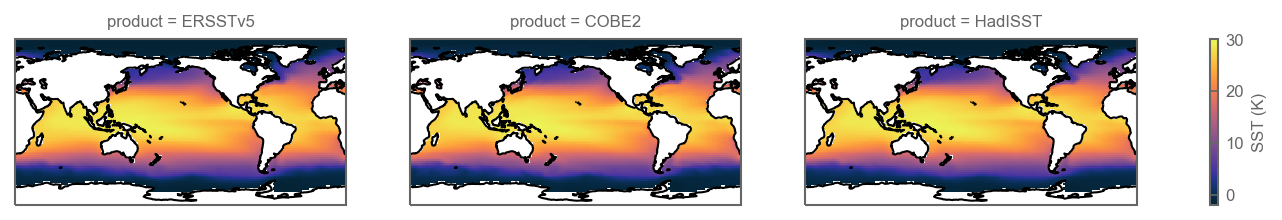

In [4]:

grid_out_2deg = xr.Dataset({'lat': (['lat'], np.arange(-89, 90, 2.)),
                            'lon': (['lon'], np.arange(1, 360, 2.))})


#---------- Load files and regridding
products_file_name = dict(ERSSTv5='ERSSTv5',COBE2='COBE2',HadISST_sst='HadISST')
products_ds = []
for file in products_file_name:
    with xr.open_dataset(f'{SST_DIR}/{file}.nc') as ds_in:
        if 'HadISST' in file:
            null_mask = ((ds_in['sst'].notnull())).isel(time=0)
            ds_in['sst'] = ds_in['sst'].where((ds_in['sst']>-100), -1.8)
            ds_in['sst'] = ds_in['sst'].where(null_mask)
        regridder = xe.Regridder(ds_in, grid_out_2deg, 'bilinear', periodic=True)
        ds_out = regridder(ds_in).sst
        ds_out = ds_out.assign_coords(time=pd.date_range(f"{ds_out.time.dt.year.values[0]}-{ds_out.time.dt.month.values[0]}",freq='MS', periods=ds_out.time.size))
        ds_out = ds_out.assign_coords(product=products_file_name[file])
        products_ds.append(ds_out)

ds_tos = xr.concat(products_ds,dim='product')
ds_tos = ds_tos.squeeze().drop_vars('lev')
ds_tos = ds_tos.sortby('lat', ascending=False)

ds_tos = ds_tos.where(ds_tos.count('product')==ds_tos.count('product').max())

#---------- Load files and regridding

ds_mask = xr.open_dataset(OCEAN_MASK_PATH).open_ocean
mask = ds_mask.interp_like(ds_tos.isel(time=0, product=0, drop=True), method='nearest')

# # Remove climatology and make anomalies
ds_tos_clim = ds_tos.sel(time=slice('1960','2024')).lntime.climato(trend=False, mean=False).load()
ds_tos_clim_ref = ds_tos_clim.sel(time=slice('1960', '1980')).mean('time')
ds_tos_anom = ds_tos_clim - ds_tos_clim_ref
ds_tos_anom_mean = ds_tos_anom.weighted(np.cos(np.deg2rad(ds_tos_anom.lat))).mean(['lon','lat'])
SSTA = ds_tos_anom - ds_tos_anom_mean
# Remove trend and acceleration from spatial anomaly field
SSTA_detrend = SSTA - xr.polyval(SSTA.time, SSTA.polyfit('time', deg=2).polyfit_coefficients)
# Remove trend and acceleration from full field
ds_tos_clim_detrend  = ds_tos_clim - xr.polyval(ds_tos_clim.time, ds_tos_clim.polyfit('time', deg=2).polyfit_coefficients)

# extract pacific data only
SSTA_pac = SSTA_detrend.where(mask.isin([2]), drop=True)



plot = ds_tos.mean('time').plot(col='product', subplot_kws=dict(projection=ccrs.PlateCarree(200)), size=1.5, aspect=2, transform=ccrs.PlateCarree(), cmap = cmo.thermal,
                                cbar_kwargs=dict(label="SST (K)"), vmin=-2, vmax=30)
for ax in plot.axs.flatten():
    ax.coastlines()

## Preprocess Green's Functions

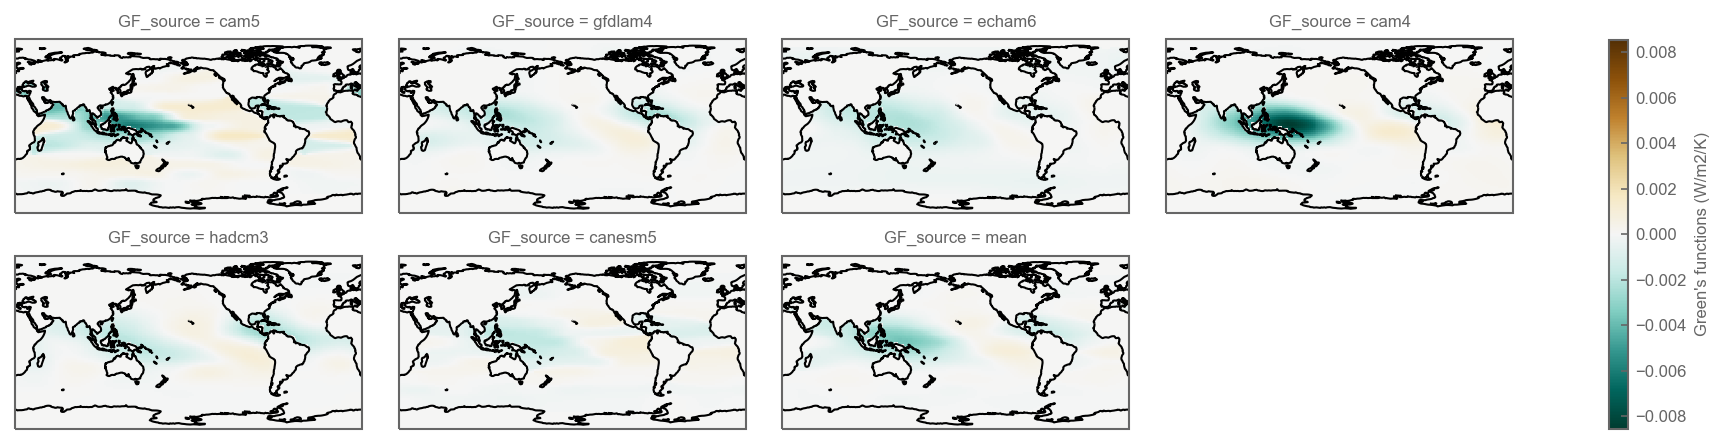

In [5]:
#---------- Load files and regridding

GF_names = dict(cam4='CAM4',cam5='CAM5', canesm5='CanESM5', echam6='ECHAM6', gfdlam4='GFDL-AM4',hadcm3='HadCM3')

list_gfs = [k.split('.')[0] for k in os.listdir(GF_DIR)]
all_gfs = []
for gf in list_gfs:
    ds = xr.open_dataset(f"{GF_DIR}/{gf}.nc").rename(longitude='lon', latitude='lat')
    if gf == 'hadcm3':
        ds = ds.assign_coords(latitude_bnds=ds.latitude_bnds.where(np.abs(ds.latitude_bnds)!=90, -ds.latitude_bnds))
    if gf=='cam4':
        da = ds.spatial_feedbacks_from_warming
    else:
        da = ds.spatial_feedbacks_from_both
    ds['mask'] = (da!=0).astype(int)
    regridder_gf = xe.Regridder(ds, grid_out_2deg, 'conservative_normed', periodic=True)
    GF_regridded = regridder_gf(da).assign_coords(GF_source=gf)
    all_gfs.append(GF_regridded)

GF = xr.concat(all_gfs, dim='GF_source')
GF = GF.where(GF!=0)
# Add mean GF
GF = xr.concat([GF, GF.where(GF.count('GF_source')==GF.count('GF_source').max()).mean('GF_source').assign_coords(GF_source='mean')], dim='GF_source')

# fill in continents/island gaps with bilinear interpolation
def fill2d(arr, x, y):
    xx, yy = np.meshgrid(x, y)
    points = np.column_stack((xx.ravel(), yy.ravel()))
    mask = ~np.isnan(arr.ravel())
    return griddata(points[mask], arr.ravel()[mask], points, method="linear").reshape(arr.shape)

GF_filled = xr.apply_ufunc(
    fill2d, GF.where(GF!=0), GF.lon, GF.lat,
    input_core_dims=[["lat","lon"], ["lon"], ["lat"]],
    output_core_dims=[["lat","lon"]],
    vectorize=True,
    dask="parallelized",
)


GF = GF_filled

#---------- multiply by fraction of ocean area

cell_area = (xr.zeros_like(ds_tos.isel(product=0, time=0, drop=True))+np.cos(np.deg2rad(ds_tos.lat))).where(ds_tos.isel(product=0, time=1000, drop=True).notnull()).fillna(0)
cell_ratio = cell_area/cell_area.sum(['lon','lat'])
GF_normed = (GF*cell_ratio).fillna(0)
GF = GF_normed

plot = GF.plot(col='GF_source', subplot_kws=dict(projection=ccrs.PlateCarree(200)), size=1.5, aspect=2, col_wrap=4, transform=ccrs.PlateCarree(), cmap = 'BrBG_r',
cbar_kwargs=dict(label="Green's functions (W/m2/K)"))
for ax in plot.axs.flatten():
    ax.coastlines()



# Processing

## Compute ENSO indices


In [6]:
def get_eof(data, n_modes=3):
    model = xeofs.models.EOF(n_modes=n_modes, use_coslat=True)
    model.fit(data, dim='time')
    components = model.components().persist()
    variance_explained = model.explained_variance_ratio().persist()*100
    timeseries = model.fit_transform(data, dim='time', normalized=False).persist()
    del components.attrs['solver_kwargs']
    del variance_explained.attrs['solver_kwargs']
    return xr.Dataset(dict(components=components, 
                           timeseries=timeseries, 
                           variance_explained=variance_explained))

def get_eof_gf(data, gf, n_modes=3):
    eof = get_eof(data*gf, n_modes=n_modes)
    eof['components_sst'] = eof.components/gf
    eof['pe'] = (eof.components*eof.timeseries).sum(['lon','lat'])
    eof['pe_total'] = (data*gf).sum(['lon','lat'])
    eof['variance_explained_pe'] = eof.pe.var('time')/eof.pe_total.var('time')*100
    return eof


In [7]:
#---------- Compute time series indices


# EP CP ENSO from https://icar.nuist.edu.cn/en/NlNinoIndices/listm.psp
nino34_bounds = {"lat": slice(5, -5), "lon": slice(190, 240)}  # 160°E to 150°W
nino3_bounds = {"lat": slice(5, -5), "lon": slice(210, 270)}  # 150°W to 90°W
nino4_bounds = {"lat": slice(5, -5), "lon": slice(160, 210)}  # 160°E to 150°W

nino34 = ds_tos_clim.sel(nino34_bounds).weighted(np.cos(np.deg2rad(ds_tos_clim.lat))).mean(['lon','lat']) 
nino3 = ds_tos_clim.sel(nino3_bounds).weighted(np.cos(np.deg2rad(ds_tos_clim.lat))).mean(['lon','lat'])
nino4 = ds_tos_clim.sel(nino4_bounds).weighted(np.cos(np.deg2rad(ds_tos_clim.lat))).mean(['lon','lat'])
alpha = xr.ones_like(nino3).where(nino3*nino4>0,0)*2/5

# Ren and Jin
EP = nino3 - alpha*nino4
CP = nino4 - alpha*nino3

# Takahashi

eofs_trop_pac_SST = xr.concat([get_eof(ds_tos_clim.where(mask==2).sel(product=product).sel(lat=slice(10,-10))).timeseries \
                                for product in tqdm(SSTA_pac.product)], dim='product')
eofs_trop_pac_SST.loc[dict(mode=2)] = -eofs_trop_pac_SST.sel(mode=2)

eofs_trop_pac_SST = eofs_trop_pac_SST/eofs_trop_pac_SST.std('time')
pc1 = eofs_trop_pac_SST.isel(mode=0)
pc2 = eofs_trop_pac_SST.isel(mode=1)


modes = xr.concat([nino34.assign_coords(mode='nino34'),
                   CP.assign_coords(mode='CP'),
                   EP.assign_coords(mode='EP'),
                   pc2.assign_coords(mode='modoki'),
                   ], dim='mode')


# smooth with 1-2-1 filter as in takahashi
w = xr.DataArray([0.25, 0.5, 0.25], dims=["window"])

modes_smooth = (
    modes
    .rolling(time=3, center=True, min_periods=3)
    .construct(time="window")
    .dot(w)  # contracts over "window"
).dropna('time')

# Re standardize
modes_smooth = modes_smooth/modes_smooth.std('time')

#---------- Spatial patterns

# Compute spatial patterns
regr_modes = xr_linregress(modes_smooth, SSTA_pac, dim='time')

#---------- Normalize
lambdas_space = regr_modes.slope.weighted(np.cos(np.deg2rad(regr_modes.lat))).std(['lon','lat'])
patterns_no_std = regr_modes.slope / lambdas_space
lambdas = lambdas_space 

modes_obs = xr.Dataset(dict(mode_pattern=regr_modes.slope,
                           mode_timeseries=modes_smooth,
                           lambdas_space=lambdas_space,
                           lambdas=lambdas))
modes_obs['pi'] = (modes_obs.mode_pattern/modes_obs.lambdas_space*GF).sum(['lon','lat'])


  0%|          | 0/3 [00:00<?, ?it/s]

## Compute Rp

In [8]:
Rp_total = (SSTA_detrend*GF).sum(['lon','lat'])
Rp_pac = (SSTA_pac*GF).sum(['lon','lat'])
Rp_all_basins =(SSTA_detrend*GF).transpose('lat','lon',...).groupby(mask.fillna(0)).sum(['lon','lat']).assign_coords(open_ocean=['none','Atlantic','Pacific','Indian','Arctic','Southern'])
Rp_all_basins = Rp_all_basins.drop_sel(open_ocean='none')

## Compute EOFs

In [9]:
all_eofs = []
for product in tqdm(SSTA_pac.product):
    all_eofs_product = []
    for GF_source in tqdm(GF.GF_source):
        eof_pac_gf = get_eof_gf(SSTA_pac.sel(product=product), GF.sel(GF_source=GF_source).fillna(0),n_modes=20).assign_coords(GF_source=GF_source)
        all_eofs_product.append(eof_pac_gf)
    eofs_pac_product = xr.concat(all_eofs_product, dim='GF_source').assign_coords(product=product)
    eofs_pac_product = eofs_pac_product.rename(dict(components="components",
                                    timeseries="timeseries",
                                    variance_explained="variance_explained",
                                    components_sst="components_sst",
                                    pe="pe",
                                    pe_total="pe_total_eofs_pac",
                                    variance_explained_pe="variance_explained_pe_eofs_pac",))
    all_eofs.append(eofs_pac_product)

# smooth with 1-2-1 filter as in takahashi
all_eofs_pac = xr.concat(all_eofs, dim='product')

all_eofs_pac['timeseries'] = (
    all_eofs_pac.timeseries
    .rolling(time=3, center=True, min_periods=3)
    .construct(time="window")
    .dot(w)  # contracts over "window"
).dropna('time')


# Normalize all patters by sign and amplitude
sign_eof = np.sign(all_eofs_pac.components_sst.sel(lon=200, lat=0, method='nearest'))
sign_eof.loc[dict(mode=2)] = -np.sign(all_eofs_pac.components_sst.sel(mode=2).where(all_eofs_pac.lat>50).mean(['lon','lat']))
sign_eof.loc[dict(mode=2, product='ERSSTv5')] = np.sign(all_eofs_pac.components_sst.sel(mode=2, product='ERSSTv5', lon =slice(245,250), lat=slice(-5,5)).mean(['lon','lat']))
sign_eof.loc[dict(mode=3)] = -sign_eof.loc[dict(mode=3)]
sign_eof.loc[dict(mode=2)] = -sign_eof.loc[dict(mode=2)]
sign_eof.loc[dict(mode=3, product='HadISST', GF_source='echam6')] = -sign_eof.loc[dict(mode=3, product='HadISST', GF_source='echam6')]



# # If doing global !!
# sign_eof.loc[dict(mode=1)] = np.sign(all_eofs_pac.components_sst.sel(mode=1, lon =slice(245,250), lat=slice(-5,5)).mean(['lon','lat']))
# sign_eof.loc[dict(mode=3, GF_source='echam6')] = np.sign(all_eofs_pac.components_sst.sel(mode=1,GF_source='echam6', lon =slice(260,300), lat=slice(-5,5)).mean(['lon','lat']))
# #######

lbd_timeseries = all_eofs_pac.timeseries.std('time')
lbd_pattern = all_eofs_pac.components_sst.weighted(np.cos(np.deg2rad(all_eofs_pac.lat))).std(['lon','lat'])

amplitude_eofs = sign_eof/lbd_pattern
all_eofs_pac['timeseries'] = all_eofs_pac['timeseries']*sign_eof/lbd_timeseries
all_eofs_pac[['components_sst','components']] =all_eofs_pac[['components_sst','components']]*sign_eof/lbd_pattern
all_eofs_pac['lambdas'] = lbd_pattern*lbd_timeseries
all_eofs_pac['pi'] = (all_eofs_pac.components_sst*GF).sum(['lon','lat'])
all_eofs_pac = all_eofs_pac.rename(mode='feature')

all_eofs_pac[['components','components_sst','pi']] = all_eofs_pac[['components','components_sst','pi']]#*np.sign(all_eofs_pac.pi)

eofs_pac = all_eofs_pac.isel(feature=np.arange(3))

eofs_pac['lambdas_scaled'] = eofs_pac.lambdas/Rp_pac.std('time')

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

## Compute PLSR

In [10]:
all_output = []
for product in SSTA_pac.product.values:
    pattern = SSTA_pac.sel(product=product, drop=True)
    all_product = []
    for gf_choice in tqdm(GF.GF_source):
        GF_mean = GF.sel(GF_source=gf_choice, drop=True)
        X = pattern#*GF_mean
        Y = Rp_pac.sel(GF_source=gf_choice, product=product)
        X = X.sel(time=Y.time)

        weights_X = xr.ones_like(X)*np.cos(np.deg2rad(GF.lat))
        X = X.stack(space=['lon','lat'])
        weights_X = weights_X.stack(space=['lon','lat'])
        X = X.dropna('space')
        weights_X = weights_X.sel(space=X.space)
        
        n_components = 20
        pls2 = PLSRegression(n_components=n_components, scale=False)
        pls2.fit(X*weights_X, Y)

        components =  xr.DataArray(pls2.x_loadings_[:]/weights_X.isel(time=range(n_components), drop=True).T, dims=['space','mode'], coords=dict(space=X.space)).unstack().sortby(['lon','lat']).transpose('mode','lat','lon')        
        timeseries =  xr.DataArray(pls2.x_scores_, dims=['time','mode'], coords=dict(time=X.time))
        components_sst = components
        components = components_sst*GF_mean
        ds_out_one = xr.Dataset(dict(components_sst=components_sst,
                                     components=components,
                                     timeseries=timeseries)).assign_coords(product=product, GF_source=gf_choice)
        ds_out_one['pe'] = (ds_out_one.components.sum(['lon','lat'])*ds_out_one.timeseries)
        all_product.append(ds_out_one)
    ds_product = xr.concat(all_product, dim='GF_source').assign_coords(mode=np.arange(1,21))
    all_output.append(ds_product)
all_plsr_pac = xr.concat(all_output, dim='product')

all_plsr_pac['timeseries'] = (
    all_plsr_pac.timeseries
    .rolling(time=3, center=True, min_periods=3)
    .construct(time="window")
    .dot(w)  # contracts over "window"
).dropna('time')

# Normalize all patters b sign and apmlitude
sign_plsr = np.sign(all_plsr_pac.components_sst.sel(lon=200, lat=0, method='nearest'))
sign_plsr.loc[dict(mode=3)] = -np.sign(all_plsr_pac.components_sst.sel(mode=3).where(all_plsr_pac.lat>50).mean(['lon','lat']))

lbd_timeseries = all_plsr_pac.timeseries.std('time')
lbd_pattern = all_plsr_pac.components_sst.weighted(np.cos(np.deg2rad(all_plsr_pac.lat))).std(['lon','lat'])

all_plsr_pac['timeseries'] = all_plsr_pac['timeseries']*sign_plsr/lbd_timeseries
all_plsr_pac[['components_sst','components']] =all_plsr_pac[['components_sst','components']]*sign_plsr/lbd_pattern
all_plsr_pac['lambdas'] = lbd_pattern*lbd_timeseries
all_plsr_pac['pi'] = (all_plsr_pac.components_sst*GF).sum(['lon','lat'])
all_plsr_pac = all_plsr_pac.rename(mode='feature')

sign_pi = np.sign(all_plsr_pac.pi)
sign_pi.loc[dict(feature=2)] = -sign_pi.loc[dict(feature=2)]

all_plsr_pac[['components','components_sst','pi','timeseries']] = all_plsr_pac[['components','components_sst','pi','timeseries']]*sign_pi

plsr_pac = all_plsr_pac.isel(feature=np.arange(3))


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

# Main Figures

## Figure 1: maps of modes

In [11]:
df_1 = eofs_pac[['pi','lambdas']].to_dataframe()
df_1['dRp_var'] = Rp_pac.var('time').to_series()
df_1['method']='EOFs'

df_2 = plsr_pac[['pi','lambdas']].to_dataframe()
df_2['dRp_var'] = Rp_pac.var('time').to_series()
df_2['method']='PLSR'

df = pd.concat([df_1,df_2])

df['lambdas_scaled'] = df.lambdas/np.sqrt(df.dRp_var)
df['lambdas_scaled_squared'] = df.lambdas**2/df.dRp_var
df['pi_scaled'] = df.pi/np.sqrt(df.dRp_var)
df['pi_scaled_squared'] = df.pi**2/df.dRp_var

df['lambdas_squared'] = df.lambdas**2
df['pi_squared'] = df.pi**2
df['sigmaRp'] = np.sqrt(df.dRp_var)
df['abs_pi'] = np.abs(df.pi)
df['var_explained'] = 100*df.pi_squared*df.lambdas_squared/df.dRp_var
df['x_value'] = df.lambdas**2/df.dRp_var
df['y_value'] = df.abs_pi**2


df_mean = df.groupby(['feature','method']).mean(numeric_only=True)
df_mean['var_explained'] = 100*(df_mean.pi_squared*df_mean.lambdas_squared/df_mean.dRp_var)
df_mean['x_value'] = df_mean.lambdas_squared/df_mean.dRp_var
df_mean['y_value'] = df_mean.pi_squared





df_modes_obs = xr.merge([Rp_total.var('time').rename('dRp_var'), modes_obs[['pi','lambdas']]]).to_dataframe()


df_modes_obs['lambdas_scaled'] = df_modes_obs.lambdas/np.sqrt(df_modes_obs.dRp_var)
df_modes_obs['lambdas_scaled_squared'] = df_modes_obs.lambdas**2/df_modes_obs.dRp_var
df_modes_obs['pi_scaled'] = df_modes_obs.pi/np.sqrt(df_modes_obs.dRp_var)
df_modes_obs['pi_scaled_squared'] = df_modes_obs.pi**2/df_modes_obs.dRp_var

df_modes_obs['lambdas_squared'] = df_modes_obs.lambdas**2
df_modes_obs['pi_squared'] = df_modes_obs.pi**2
df_modes_obs['sigmaRp'] = np.sqrt(df_modes_obs.dRp_var)
df_modes_obs['abs_pi'] = np.abs(df_modes_obs.pi)
df_modes_obs['var_explained'] = 100*df_modes_obs.pi_squared*df_modes_obs.lambdas_squared/df_modes_obs.dRp_var
df_modes_obs['x_value'] = df_modes_obs.lambdas**2/df_modes_obs.dRp_var
df_modes_obs['y_value'] = df_modes_obs.abs_pi**2


df_modes_obs_mean = df_modes_obs.groupby(['mode']).mean(numeric_only=True)
df_modes_obs_mean['var_explained'] = 100*(df_modes_obs_mean.pi_squared*df_modes_obs_mean.lambdas_squared/df_modes_obs_mean.dRp_var)
df_modes_obs_mean['x_value'] = df_modes_obs_mean.lambdas_squared/df_modes_obs_mean.dRp_var
df_modes_obs_mean['y_value'] = df_modes_obs_mean.pi_squared

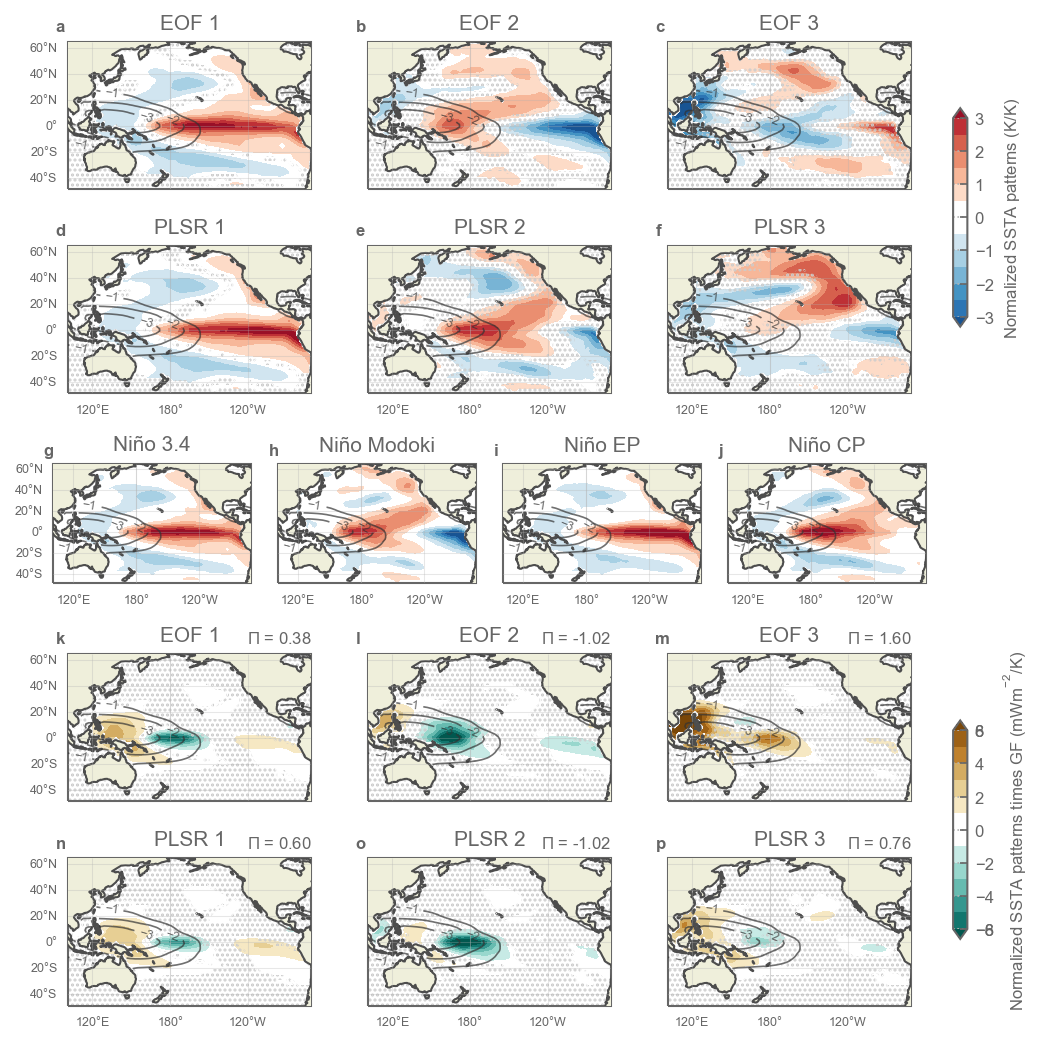

In [12]:
mean_eofs = eofs_pac.mean(['GF_source','product'])
mean_plsr = plsr_pac.mean(['GF_source','product'])

fig, axs = plt.subplot_mosaic("""
                              AAAABBBBCCCCy
                              DDDDEEEEFFFFy
                              MMMNNNOOOPPP.
                              GGGGHHHHIIIIx
                              JJJJKKKKLLLLx
                              """,
                              figsize=(7,7),
                              width_ratios=[5,5,5,5,5,5,5,5,5,5,5,5,1.5],
                              height_ratios=[10,10,10,10,10],
                              per_subplot_kw=dict(ABCDEFGHIJKLMNOP=dict(projection=ccrs.PlateCarree(200))))
palette_sst=sns.color_palette('RdBu_r',n_colors=14)
palette_sst[6] = (1,1,1)
palette_sst[7] = (1,1,1)
palette_gf=sns.color_palette('BrBG_r',n_colors=14)
palette_gf[6] = (1,1,1)
palette_gf[7] = (1,1,1)
palette_gf

axs_sst_eof = ['A','B','C']
axs_sst_plsr = ['D','E','F']
axs_modes = ['M','N','O','P']
axs_gf_eof = ['G','H','I']
axs_gf_plsr = ['J','K','L']
all_axs= axs_sst_eof+axs_sst_plsr+axs_modes+axs_gf_eof+axs_gf_plsr

levels_gf = np.arange(-6,6.1, 1)
levels_sst = np.arange(-3,3.1,.5) 


mean_eofs = eofs_pac.mean(['GF_source','product'])
mean_plsr = plsr_pac.mean(['GF_source','product'])
mean_gf = GF.sel(GF_source='mean', lon=mean_eofs.lon, lat=mean_eofs.lat)
mean_gf=mean_gf.where(mean_gf!=0)


mean_eofs['components_sst'] = (mean_eofs['components_sst']/mean_eofs['components_sst'].weighted(np.cos(np.deg2rad(mean_eofs.lat))).std(['lon','lat']))
mean_eofs['components'] = mean_eofs.components_sst*mean_gf
mean_plsr['components_sst'] = (mean_plsr['components_sst']/mean_plsr['components_sst'].weighted(np.cos(np.deg2rad(mean_plsr.lat))).std(['lon','lat']))
mean_plsr['components'] = mean_plsr.components_sst*mean_gf

sign_agreement_eof = (np.abs(np.sign(eofs_pac.components_sst).sum(['product','GF_source']))>18)
sign_agreement_plsr = (np.abs(np.sign(plsr_pac.components_sst).sum(['product','GF_source']))>18)

sign_agreement_eof_gf = (np.abs(np.sign(eofs_pac.components).sum(['product','GF_source']))>18)
sign_agreement_plsr_gf = (np.abs(np.sign(plsr_pac.components).sum(['product','GF_source']))>18)

plt.rcParams['hatch.color'] = '.8'
for k in range(3):
    
    (1000*mean_eofs.components).sel(feature=k+1).plot.contourf(ax=axs[axs_gf_eof[k]], transform=ccrs.PlateCarree(), levels=levels_gf, cbar_ax=axs['x'], extend='both', colors=palette_gf)
    (mean_eofs.components_sst.sel(feature=k+1)).plot.contourf(ax=axs[axs_sst_eof[k]], transform=ccrs.PlateCarree(), levels=levels_sst, cbar_ax=axs['y'], extend='both', colors=palette_sst)
    sign_agreement_eof.sel(feature=k+1).plot.contourf(hatches=['.....', '', ''], alpha=0, ax=axs[axs_sst_eof[k]], transform=ccrs.PlateCarree(), add_colorbar=False, )
    sign_agreement_eof_gf.sel(feature=k+1).plot.contourf(hatches=['.....', '', ''], alpha=0, ax=axs[axs_gf_eof[k]], transform=ccrs.PlateCarree(), add_colorbar=False, )

    (1000*mean_plsr.components).sel(feature=k+1).plot.contourf(ax=axs[axs_gf_plsr[k]], transform=ccrs.PlateCarree(), levels=levels_gf, cbar_ax=axs['x'], extend='both', colors=palette_gf)
    (mean_plsr.components_sst.sel(feature=k+1)).plot.contourf(ax=axs[axs_sst_plsr[k]], transform=ccrs.PlateCarree(), levels=levels_sst, cbar_ax=axs['y'], extend='both', colors=palette_sst)
    sign_agreement_plsr.sel(feature=k+1).plot.contourf(hatches=['.....', '', ''], alpha=0, ax=axs[axs_sst_plsr[k]], transform=ccrs.PlateCarree(), add_colorbar=False, )
    sign_agreement_plsr_gf.sel(feature=k+1).plot.contourf(hatches=['.....', '', ''], alpha=0, ax=axs[axs_gf_plsr[k]], transform=ccrs.PlateCarree(), add_colorbar=False, )


modes_pattern_mean = modes_obs.mode_pattern.mean('product')
modes_pattern_mean = modes_pattern_mean/modes_pattern_mean.weighted(np.cos(np.deg2rad(mean_plsr.lat))).std(['lon','lat'])

modes_pattern_mean.sel(mode='nino34').plot.contourf(ax=axs['M'], transform=ccrs.PlateCarree(), levels=levels_sst, add_colorbar=False, extend='both', colors=palette_sst)
(modes_pattern_mean.sel(mode='modoki')).plot.contourf(ax=axs['N'], transform=ccrs.PlateCarree(), levels=levels_sst, add_colorbar=False, extend='both', colors=palette_sst)
modes_pattern_mean.sel(mode='EP').plot.contourf(ax=axs['O'], transform=ccrs.PlateCarree(), levels=levels_sst, add_colorbar=False, extend='both', colors=palette_sst)
(modes_pattern_mean.sel(mode='CP')).plot.contourf(ax=axs['P'], transform=ccrs.PlateCarree(), levels=levels_sst, add_colorbar=False, extend='both', colors=palette_sst)

axs['x'].set_yticks(np.arange(-8,8.1, 2))
axs['y'].set_yticks(np.arange(-3,3.1,1))
axs['x'].minorticks_off()
axs['y'].minorticks_off()
axs['x'].set_ylabel(r'Normalized $SSTA$ patterns times $GF$ (mWm$^{-2}/K$)')
axs['y'].set_ylabel(r'Normalized $SSTA$ patterns (K/K)')

for k,letter in enumerate(all_axs):
    ax=axs[letter]
    ax.add_feature(cfeat.LAND, edgecolor='.3', zorder=100)
    ax.set_title('')
    c = (mean_gf.sel(lon=mean_eofs.lon, lat=mean_eofs.lat)*1000).plot.contour(levels=[-4,-3,-2,-1,1], extend='both', ax=ax, 
                                                                          zorder=1000, colors='.2', transform=ccrs.PlateCarree(),
                                                                          linewidths=.8, linestyles=['-','-','-','-','--'], alpha=.7)
    ax.clabel(c, c.levels, fmt=None, fontsize=6)
    gl = ax.gridlines(draw_labels=True, alpha=.3, linestyle='-', zorder=100, lw=.5)
    if letter not in axs_gf_plsr+axs_sst_plsr+axs_modes:
        gl.bottom_labels=False
    if True:
        gl.top_labels=False
    if letter not in ['A','D','M','G','J']:
        gl.left_labels=False
    gl.ylabel_style=dict(size=6)
    gl.xlabel_style=dict(size=6)
    label = chr(ord('a')+k)
    ax.text(-.05,1.05, label, weight='bold', ha='left', va='bottom', transform=ax.transAxes)
    ax.set_ylabel('')

    
for k, letter in enumerate(axs_gf_eof):
    ax=axs[letter]
    df_modes_obs.pi
    ax.text(1,1.05, r"$\Pi$"+f" = {mean_eofs.pi.isel(feature=k).values:.02f}", weight='normal', ha='right', va='bottom', transform=ax.transAxes)
for k, letter in enumerate(axs_gf_plsr):
    ax=axs[letter]
    ax.text(1,1.05, r"$\Pi$"+f" = {mean_plsr.pi.isel(feature=k).values:.02f}", weight='normal', ha='right', va='bottom', transform=ax.transAxes)

for k,letters in enumerate(zip(axs_sst_eof,axs_sst_plsr,axs_gf_eof,axs_gf_plsr)):
    a,b,c,d = letters
    axs[a].set_title(f'EOF {k+1}')
    axs[b].set_title(f'PLSR {k+1}')
    axs[c].set_title(f'EOF {k+1}')
    axs[d].set_title(f'PLSR {k+1}')


axs['M'].set_title('Niño 3.4')
axs['N'].set_title('Niño Modoki')
axs['O'].set_title('Niño EP')
axs['P'].set_title('Niño CP')
plt.tight_layout()


plt.savefig('plots/maps_features_with_modes.pdf', dpi=300)


## Figure 2: Comparison with ENSO

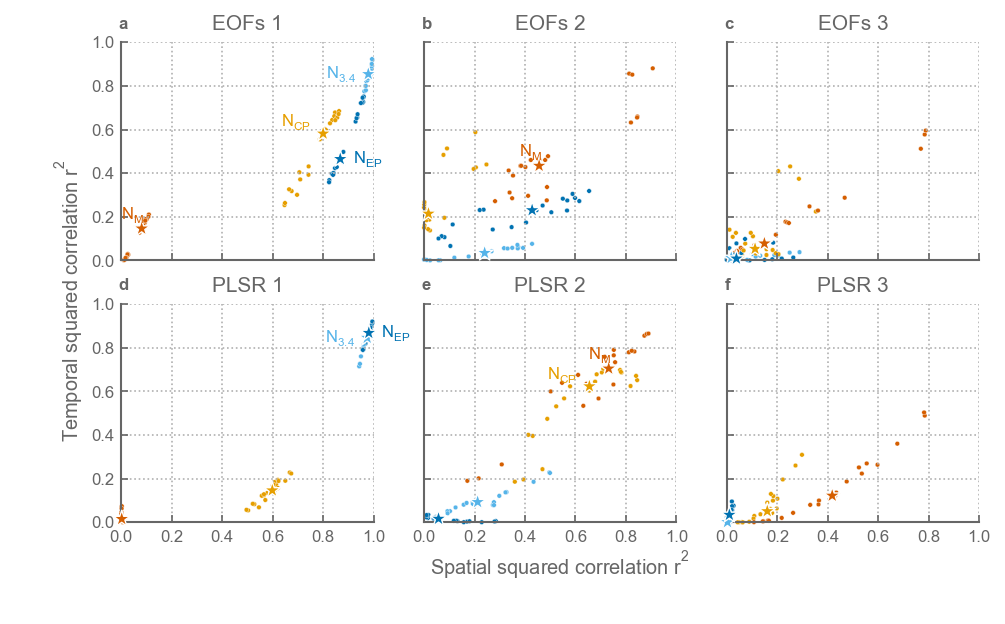

In [13]:
ds_features = xr.concat([eofs_pac.assign_coords(method='EOFs'), plsr_pac.assign_coords(method='PLSR')], dim='method')
temp_regr = xr_linregress(modes,ds_features.timeseries)
space_regr1 = xr_linregress(regr_modes.slope,ds_features.components_sst, dim=['lon','lat']).r_value
space_regr = xr.corr(regr_modes.slope,ds_features.components_sst, dim=['lon','lat'], weights = np.cos(np.deg2rad(regr_modes.lat)))

regr_both = xr.Dataset(dict(regr_space=space_regr,regr_time=temp_regr.r_value))
df_regr_mean = ((regr_both**2).median(['GF_source','product']).to_dataframe()).reset_index()
df_regr_mean['feature'] = 'Feature '+df_regr_mean['feature'].astype(str) 

df_regr_all = ((regr_both).to_dataframe()).reset_index()
df_regr_all['feature'] = 'Feature '+df_regr_all['feature'].astype(str) 

fig, axs = plt.subplots(2,3, figsize=(6.5, 4), sharex=True, sharey=True)

for k, ax in enumerate(axs.flatten()):
    feature = k%3
    method = k//3
    regr_plot = regr_both.sel(mode=['nino34','CP','EP' ,'modoki']).isel(method=method, feature=feature)**2
    df_ = regr_plot.to_dataframe().reset_index()
    df_mean = regr_plot.median(['GF_source', 'product']).to_dataframe().reset_index()
    sns.scatterplot(df_,x='regr_space',y='regr_time', ax=ax, hue='mode', s=5, legend=False, alpha=1,edgecolor='1', clip_on=False, palette=[color_palette_enso[0],color_palette_enso[1],color_palette_enso[3],color_palette_enso[2]])
    sns.scatterplot(df_mean,x='regr_space',y='regr_time', ax=ax, hue='mode', s=70, zorder=100, clip_on=False, marker='*', edgecolor='1', palette=[color_palette_enso[0],color_palette_enso[1],color_palette_enso[3],color_palette_enso[2]])
    ax.set(xlim=(0,1), ylim=(0,1))
    ax.set(xlabel='', ylabel='')
    ax.set_title(f"{regr_plot.method.values} {feature+1}")
    ax.legend().remove()
    if k in [0,3]:
        ax.text(df_mean.iloc[0].regr_space-.05, df_mean.iloc[0].regr_time, 'N$_{3.4}$', color=color_palette_enso[0], ha='right', va='center',zorder=100)
        ax.text(df_mean.iloc[2].regr_space+.05, df_mean.iloc[2].regr_time, 'N$_{EP}$', color=color_palette_enso[3], ha='left', va='center',zorder=100)
    if k in [0,4]:
        ax.text(df_mean.iloc[1].regr_space-.05, df_mean.iloc[1].regr_time+0.05, 'N$_{CP}$', color=color_palette_enso[1], ha='right', va='center',zorder=100)
    if k in [0,1,4]:
        ax.text(df_mean.iloc[3].regr_space+.01, df_mean.iloc[3].regr_time+0.06, 'N$_{M}$', color=color_palette_enso[2], ha='right', va='center',zorder=100)
    ax.text(-.01, 1.05, chr(ord('a')+k), transform=ax.transAxes, ha='left', va='bottom', weight='bold')
    
fig.supxlabel('Spatial squared correlation r$^2$',y=0.03, x=.55)
fig.supylabel('Temporal squared correlation r$^2$', x=0.03, ha='left')

plt.subplots_adjust(left=.1, bottom=.13, right=0.98, top=.93)

plt.savefig('plots/Correlation_features_with_modes.pdf')

## Figure 3: Contribution to Pattern Effect

/home/rguillaume/virtual_envs/phd/lib/python3.10/site-packages/xarray/plot/dataarray_plot.py:2134: UserWarning: linewidths is ignored by contourf
  primitive = ax.contourf(x, y, z, **kwargs)


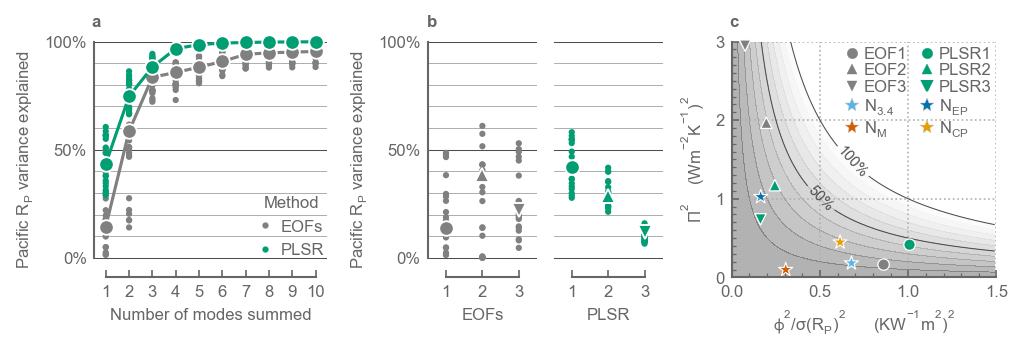

In [14]:

fig, axs = plt.subplot_mosaic("""
                              ABCD
                              """, figsize=(7,2.4), 
                              gridspec_kw=dict(width_ratios=[3,1,1,3])
                              )

df_1 = eofs_pac[['pi','lambdas']].to_dataframe()
df_1['dRp_var'] = Rp_pac.var('time').to_series()
df_1['method']='EOFs'

df_2 = plsr_pac[['pi','lambdas']].to_dataframe()
df_2['dRp_var'] = Rp_pac.var('time').to_series()
df_2['method']='PLSR'

df = pd.concat([df_1,df_2])

df['lambdas_scaled'] = df.lambdas/np.sqrt(df.dRp_var)
df['lambdas_scaled_squared'] = df.lambdas**2/df.dRp_var
df['pi_scaled'] = df.pi/np.sqrt(df.dRp_var)
df['pi_scaled_squared'] = df.pi**2/df.dRp_var

df['lambdas_squared'] = df.lambdas**2
df['pi_squared'] = df.pi**2
df['sigmaRp'] = np.sqrt(df.dRp_var)
df['abs_pi'] = np.abs(df.pi)
df['var_explained'] = 100*df.pi_squared*df.lambdas_squared/df.dRp_var
df['x_value'] = df.lambdas**2/df.dRp_var
df['y_value'] = df.abs_pi**2


df_mean = df.groupby(['feature','method']).mean(numeric_only=True)
df_mean['var_explained'] = 100*(df_mean.pi_squared*df_mean.lambdas_squared/df_mean.dRp_var)

df_mean['x_value'] = df_mean.lambdas_squared/df_mean.dRp_var
df_mean['y_value'] = df_mean.pi_squared


#### First panel

var_cum_eof = all_eofs_pac.pe.cumsum('feature').var('time')
var_cum_plsr = all_plsr_pac.pe.cumsum('feature').var('time')
var_cum_ratio_eof = 100*var_cum_eof/Rp_pac.var('time')
var_cum_ratio_plsr = 100*var_cum_plsr/Rp_pac.var('time')

var_cum_ratio_mean_eof = 100*var_cum_eof.mean(['product','GF_source'])/Rp_pac.var('time').mean(['product','GF_source'])
var_cum_ratio_mean_plsr = 100*var_cum_plsr.mean(['product','GF_source'])/Rp_pac.var('time').mean(['product','GF_source'])

df_cum_1 = var_cum_ratio_eof.rename('var_ratio').to_series().reset_index()
df_cum_2 = var_cum_ratio_plsr.rename('var_ratio').to_series().reset_index()
df_cum_1['method'] = 'EOFs'
df_cum_2['method'] = 'PLSR'
df_cum = pd.concat([df_cum_1, df_cum_2])

df_cum_mean_1 = var_cum_ratio_mean_eof.rename('var_ratio').to_series().reset_index()
df_cum_mean_2 = var_cum_ratio_mean_plsr.rename('var_ratio').to_series().reset_index()
df_cum_mean_1['method']= 'EOFs'
df_cum_mean_2['method'] = 'plPLSRsr'
df_cum_mean = pd.concat([df_cum_mean_1, df_cum_mean_2])

sns.stripplot(df_cum.query("feature<11"), x='feature',y='var_ratio' , jitter=False, s=3, dodge=False, hue='method', palette=['0.5','C2'],ax=axs['A'])
sns.pointplot(df_cum_mean.query("feature<11"), x='feature',y='var_ratio', dodge=False, hue='method', linewidth=1.5,palette=['0.5','C2'],markeredgecolor='1', zorder=100, markeredgewidth=.9, markersize=7,ax=axs['A'], legend=False, clip_on=False)

axs['A'].set_ylim(-9,100)
axs['A'].set_xlabel('')
sns.despine(ax=axs['A'], trim=True)
axs['A'].yaxis.set_major_formatter("{x:.0f}%")

axs['A'].yaxis.set_minor_locator(plt.MultipleLocator(10))
axs['A'].yaxis.set_major_locator(plt.MultipleLocator(50))
axs['A'].grid(which='minor', ls='-',color='.5', linewidth=.3, axis='y')
axs['A'].grid(which='major', ls='-',color='.3', linewidth=.5, axis='y')
axs['A'].tick_params(left=False, which='both')
axs['A'].set_ylabel('Pacific '+r'R$_P$'+' variance explained')
axs['A'].legend(title='Method', loc='lower right', bbox_to_anchor=(1.05,0.02))
axs['A'].set_xlabel('Number of modes summed')



############## Second panel


sns.stripplot(df.query("feature<4 & method=='EOFs'"), x='feature',y='var_explained' , jitter=False, s=3, dodge=False, hue='method', palette=['0.5'], legend=False, ax=axs['B'],)
sns.pointplot(df_mean.query("feature<4 & method=='EOFs'"), x='feature',y='var_explained', dodge=False, hue='feature',markers=['o','^','v'], palette=['0.5','0.5','0.5'],markeredgecolor='1', zorder=100, markeredgewidth=.9, markersize=7,linewidth=0, legend=False, ax=axs['B'],)

sns.stripplot(df.query("feature<4 & method=='PLSR'"), x='feature',y='var_explained' , jitter=False, s=3, dodge=False, hue='method', palette=['C2'], legend=False, ax=axs['C'])
sns.pointplot(df_mean.query("feature<4 & method=='PLSR'"), x='feature',y='var_explained', dodge=False, hue='feature',markers=['o','^','v'], palette=['C2','C2','C2'],markeredgecolor='1', zorder=100, markeredgewidth=.9, markersize=7,linewidth=0, legend=False, ax=axs['C'],)

for ax in [axs['C'],axs['B']]:
    ax.set_ylim(-9,100)
    ax.set_xlabel('')
    sns.despine(ax=ax, trim=True)
    ax.yaxis.set_major_formatter("{x:.0f}%")
    ax.set_xticks([0,1,2])
    ax.set_xlabel('')
    ax.yaxis.set_minor_locator(plt.MultipleLocator(10))
    ax.yaxis.set_major_locator(plt.MultipleLocator(50))
    ax.grid(which='minor', ls='-',color='.5', linewidth=.3, axis='y')
    ax.grid(which='major', ls='-',color='.3', linewidth=.5, axis='y')
    ax.tick_params(left=False, which='both')

axs["C"].tick_params(left=False,labelleft=False)
sns.despine(ax=axs["C"], left=True)
axs['C'].set_ylabel('')
axs['C'].set_xlabel('PLSR')
axs['B'].set_xlabel('EOFs')
axs['B'].set_ylabel('Pacific '+r'R$_P$'+' variance explained')


###### Third panel


x_value_text = df_mean.x_value.copy()
x_value_text.loc[x_value_text.index.get_level_values(0)==1] = x_value_text-0.01
df_mean['x_value_text'] = x_value_text

sns.scatterplot(df_mean, x='x_value', y='y_value', hue='method', palette=['0.5','C2'],
              s=30, zorder=100, legend=False,ax=axs['D'], style='feature', linewidth=.6,markers=['o','^','v'], 
              clip_on=False, edgecolor='1')

pis = xr.DataArray(np.arange(0,3.1,.1), dims=['pi'], coords=dict(pi = np.arange(0,3.1,.1)))
lambdas = xr.DataArray(np.arange(0,1.5,.01), dims=['lambdas'], coords=dict(lambdas = np.arange(0,1.5,.01)))
var_explained_contours = 100*((np.abs(pis)*lambdas))

c1 = var_explained_contours.plot.contour(levels=np.arange(50,101,50),colors='.3', linewidths=.5,ax=axs['D'])
c1_ = var_explained_contours.plot.contourf(levels=[10,20,30,40,50,60,70,80,90,100],cmap='Greys_r', 
                                          linewidths=0,ax=axs['D'], add_colorbar=False, alpha=.3,)

axs['D'].clabel(c1, fmt=lambda x:f"{x:.0f}%", fontsize=7,manual=[(0.5,1),(0.7,1.5)])

plt.tight_layout()

axs['D'].xaxis.set_major_locator(plt.MultipleLocator(.5))
axs['D'].yaxis.set_major_locator(plt.MultipleLocator(1))
axs['D'].xaxis.set_minor_locator(plt.MultipleLocator(0.1))
axs['D'].yaxis.set_minor_locator(plt.MultipleLocator(.1))

axs['D'].set_ylim(0,3)
sns.despine(ax=axs['D'],)
axs['D'].set_xlim(0,1.5)
axs['D'].set_ylabel('$\Pi^2$    ($Wm^{-2}K^{-1}$)$^2$')
axs['D'].set_xlabel('$\phi^2/\sigma(R_P)^2$      ($KW^{-1}m^{2}$)$^2$')

legend_elements = [Line2D([0], [0], marker='o', color='.5', label='EOF1',linewidth=0,markeredgewidth=.2,
                          markerfacecolor='.5', markersize=5),
                   Line2D([0], [0], marker='^', color='.5', label='EOF2',linewidth=0,markeredgewidth=.2,
                          markerfacecolor='.5', markersize=5),
                   Line2D([0], [0], marker='v', color='.5', label='EOF3',linewidth=0,markeredgewidth=.2,
                          markerfacecolor='.5', markersize=5),
                   Line2D([0], [0], marker='*', color='.8', label='$N_{3.4}$',linewidth=0,markeredgewidth=.2,
                          markerfacecolor=color_palette_enso[0], markersize=7),
                   Line2D([0], [0], marker='*', color='.8', label='$N_M$',linewidth=0,markeredgewidth=.2,
                          markerfacecolor=color_palette_enso[2], markersize=7),
                   
                   Line2D([0], [0], marker='o', color='C2', label='PLSR1',linewidth=0,markeredgewidth=.2,
                          markerfacecolor='C2', markersize=5),
                   Line2D([0], [0], marker='^', color='C2', label='PLSR2',linewidth=0,markeredgewidth=.2,
                          markerfacecolor='C2', markersize=5),
                   Line2D([0], [0], marker='v', color='C2', label='PLSR3',linewidth=0,
                          markerfacecolor='C2', markersize=5),
                   Line2D([0], [0], marker='*', color='.8', label='$N_{EP}$',linewidth=0,markeredgewidth=.2,
                          markerfacecolor=color_palette_enso[3], markersize=7),
                   Line2D([0], [0], marker='*', color='.8', label='$N_{CP}$',linewidth=0,markeredgewidth=.2,
                          markerfacecolor=color_palette_enso[1], markersize=7),
                   
                   ]
sns.scatterplot(df_modes_obs_mean.loc[['nino34','EP','CP','modoki']],x='x_value', y='y_value', ax=axs['D'],hue='mode', marker='*', s=50, palette=color_palette_enso, legend=False)

axs['D'].legend(handles = legend_elements,ncols=2, loc='upper right', bbox_to_anchor=(1,1), borderpad=0, labelspacing=0.1, handletextpad=.3, borderaxespad=.3, columnspacing=.8)


####### Final tweaks 



axs['A'].text(-.01, 1.05,'a', transform=axs['A'].transAxes, ha='left', va='bottom', weight='bold')
axs['B'].text(-.01, 1.05, 'b', transform=axs['B'].transAxes, ha='left', va='bottom', weight='bold')
axs['D'].text(-.01, 1.05, 'c', transform=axs['D'].transAxes, ha='left', va='bottom', weight='bold')

plt.tight_layout()


pos_B = axs["B"].get_position()
pos_C = axs["C"].get_position()
pos_D = axs["D"].get_position()


axs["B"].set_position([pos_B.x0, pos_B.y0, pos_B.width+.03, pos_B.height])
axs["C"].set_position([pos_C.x0-0.05, pos_C.y0, pos_C.width+.03, pos_C.height])
axs["D"].set_position([pos_D.x0-0.05, pos_D.y0, pos_D.width+.03, pos_D.height])

legend_handles = axs['D'].get_legend_handles_labels()



plt.savefig('plots/percent_variance_explained_by_modes_v2.pdf')


In [15]:

df_mean = df.groupby(['feature','method']).mean(numeric_only=True)
df_mean['var_explained'] = 100*(df_mean.pi_squared*df_mean.lambdas_squared/df_mean.dRp_var)
df_mean['x_value'] = df_mean.lambdas
df_mean['y_value'] = df_mean.pi/df_mean.sigmaRp

df_mean

pi   lambdas   dRp_var  lambdas_scaled  \
feature method                                                 
1       EOFs    0.377628  0.270872  0.085412        1.150070   
        PLSR    0.597842  0.293293  0.085412        1.232553   
2       EOFs   -1.022631  0.128983  0.085412        0.538870   
        PLSR   -1.016666  0.143463  0.085412        0.597764   
3       EOFs    1.602960  0.079390  0.085412        0.342327   
        PLSR    0.758137  0.117425  0.085412        0.493925   

                lambdas_scaled_squared  pi_scaled  pi_scaled_squared  \
feature method                                                         
1       EOFs                  1.469065   1.479173           2.555344   
        PLSR                  1.660830   2.210919           4.942499   
2       EOFs                  0.315944  -3.133691          14.667611   
        PLSR                  0.391543  -3.846376          15.202463   
3       EOFs                  0.135533   6.140381          40.858389   
        PLSR                  0.268101   2.739287           7.730358   

                lambdas_squared  pi_squared   sigmaRp    abs_pi  \
feature method                                                    
1       EOFs           0.073503    0.162579  0.270456  0.377628   
        PLSR           0.086056    0.415711  0.270456  0.597842   
2       EOFs           0.016717    1.967559  0.270456  1.045246   
        PLSR           0.020836    1.172764  0.270456  1.016666   
3       EOFs           0.006418    2.948008  0.270456  1.602960   
        PLSR           0.013888    0.737683  0.270456  0.758137   

                var_explained   x_value   y_value  
feature method                                     
1       EOFs        13.990952  0.270872  1.396263  
        PLSR        41.884417  0.293293  2.210498  
2       EOFs        38.508230  0.128983 -3.781134  
        PLSR        28.608821  0.143463 -3.759080  
3       EOFs        22.150734  0.079390  5.926878  
        PLSR        11.994477  0.117425  2.803182

In [16]:
df_mode = xr.merge([modes_obs[['pi','lambdas']], Rp_pac.var('time').rename('dRp_var')]).to_dataframe().reset_index()
df_mode['lambdas_scaled'] = df_mode.lambdas/np.sqrt(df_mode.dRp_var)
df_mode['lambdas_scaled_squared'] = df_mode.lambdas**2/df_mode.dRp_var
df_mode['lambdas_squared'] = df_mode.lambdas**2
df_mode['pi_squared'] = df_mode.pi**2
df_mode['sigmaRp'] = np.sqrt(df_mode.dRp_var)
df_mode['abs_pi'] = np.abs(df_mode.pi)
df_mode['var_explained'] = 100*df_mode.pi_squared*df_mode.lambdas_squared/df_mode.dRp_var
df_mode['x_value'] = df_mode.lambdas**2/df_mode.dRp_var
df_mode['y_value'] = df_mode.abs_pi**2

df_mean_mode = df_mode.groupby(['mode']).mean(numeric_only=True)
df_mean_mode['var_explained'] = 100*(df_mean_mode.pi_squared*df_mean_mode.lambdas_squared/df_mean_mode.dRp_var)
df_mean_mode['x_value'] = df_mean_mode.lambdas
df_mean_mode['y_value'] = df_mean_mode.pi/df_mean_mode.sigmaRp

df_mean_mode = df_mean_mode.loc[['nino34','EP','CP', 'modoki']]
df_mean_mode

,pi,lambdas,dRp_var,lambdas_scaled,lambdas_scaled_squared,lambdas_squared,pi_squared,sigmaRp,abs_pi,var_explained,x_value,y_value
mode,,,,,,,,,,,,
nino34,0.391298,0.293730,0.085412,1.235339,1.671340,0.086283,0.181205,0.270456,0.391298,18.305213,0.293730,1.446808
EP,0.608802,0.279415,0.085412,1.175259,1.512981,0.078074,0.447356,0.270456,0.608802,40.892009,0.279415,2.251019
CP,-0.202570,0.197158,0.085412,0.829074,0.752814,0.038887,0.097841,0.270456,0.233963,4.454523,0.197158,-0.748996
modoki,-0.865719,0.144336,0.085412,0.606937,0.403354,0.020836,1.024891,0.270456,0.865719,25.001425,0.144336,-3.200960


## Figure 4: Lag-regressions with CERES

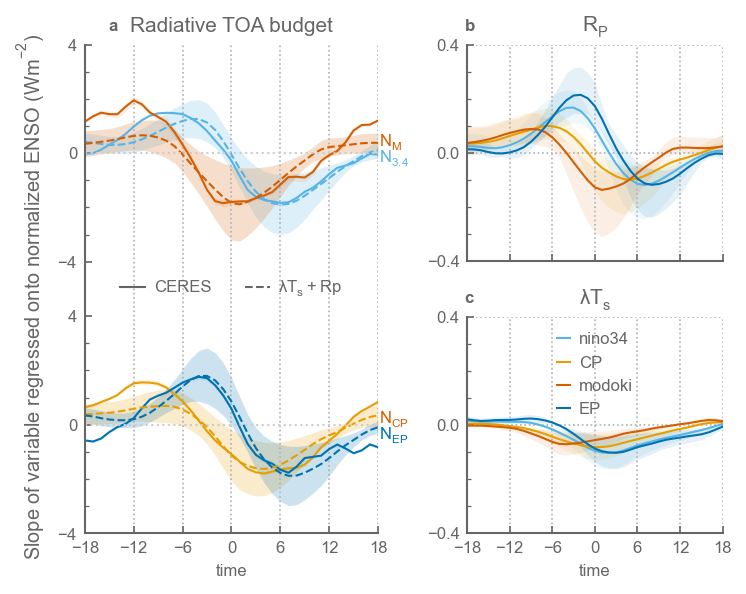

In [17]:
ds_ceres = xr.open_dataset('/projets/EMC2/data/Observations/EEI/CERES/CERES_EBAF-TOA_Ed4.2.1_Subset_200003-202411.nc')
ds_ceres['time'] = pd.date_range(f'{ds_ceres.time.dt.year.values[0]}-{ds_ceres.time.dt.month.values[0]}', freq='MS', periods=ds_ceres.time.size)
ds_ceres = ds_ceres.sel(time=slice('2000-11', '2024-11')).lntime.climato(trend=False).gtoa_net_all_mon

ds_tas = xr.open_dataset('/projets/EMC2/data/Observations/TAS/HadCRUT.5.0.2.0.analysis.summary_series.global.monthly.nc').tas_mean
ds_tas['time'] = pd.date_range(f'{ds_tas.time.dt.year.values[0]}-{ds_tas.time.dt.month.values[0]}', freq='MS', periods=ds_tas.time.size)
ds_tas = ds_tas.sel(time=ds_ceres.time).lntime.climato(trend=False)


# IPCC estimates for lambda: –1.16 [–1.81 to –0.51] median+90% ci

P95 = -1.81
P5 = -0.51
mu = -1.16

sigma = (P5-P95)/2/1.645
lambda_dist = xr.DataArray(np.random.normal(loc=mu, scale=sigma, size=100), dims=['lbd_sample'], coords=dict(lbd_sample=np.arange(100)))


modes_notrend = (modes_obs.mode_timeseries.sel(time=ds_ceres.time)).lntime.climato(trend=False, mean=False).sel(mode=['nino34','EP','CP', 'modoki'])
ceres_notrend = ds_ceres.sel(time=ds_ceres.time).lntime.climato(trend=False, mean=False)
lbd_tas_notrend = ds_tas.sel(time=ds_ceres.time).lntime.climato(trend=False, mean=False)*lambda_dist
Rp_notrend = Rp_total.sel(time=ds_ceres.time).lntime.climato(trend=False, mean=False)

ds_ceres_lag = xr.concat([xr_linregress(modes_notrend.shift(time=k), ceres_notrend).assign_coords(lag=k) for k in range(-18,19)], dim='lag').slope
ds_temp_lag = xr.concat([xr_linregress(modes_notrend.shift(time=k), lbd_tas_notrend).assign_coords(lag=k) for k in range(-18,19)], dim='lag').slope
ds_pattern_lag = xr.concat([xr_linregress(modes_notrend.shift(time=k), Rp_notrend).assign_coords(lag=k) for k in range(-18,19)], dim='lag').slope
ds_both_lag = xr.concat([xr_linregress(modes_notrend.shift(time=k),lbd_tas_notrend+Rp_notrend).assign_coords(lag=k) for k in range(-18,19)], dim='lag').slope




fig, axs = plt.subplot_mosaic("""
                              AB
                              AC
                              """,figsize=(5,4), sharex=True,)

offset=1


ds_ceres_lag.sel(mode=['nino34','modoki']).rename(lag='time').lntime.plot(hue='mode', ax=axs['A'], shaded_area='quantiles', thick_line='mean', shaded_area_alpha=.1, color=[color_palette_enso[0],color_palette_enso[2]])
# ds_ceres_lag.sel(mode=['CP','EP']).rename(lag='time').lntime.plot(hue='mode', ax=axs['A'], shaded_area='quantiles', thick_line='mean', shaded_area_alpha=.1, color='.7', label=False, line_kwargs=dict(linewidth=.5))

(ds_ceres_lag-offset).sel(mode=['CP','EP']).rename(lag='time').lntime.plot(hue='mode', ax=axs['A'], shaded_area='quantiles', thick_line='mean', shaded_area_alpha=.1, color=[color_palette_enso[1],color_palette_enso[3]])
# (ds_ceres_lag-offset).sel(mode=['nino34','modoki']).rename(lag='time').lntime.plot(hue='mode', ax=axs['A'], shaded_area='quantiles', thick_line='mean', shaded_area_alpha=.1, color='.7', label=False, line_kwargs=dict(linewidth=.5))


(ds_pattern_lag+ds_temp_lag).sel(mode=['nino34','modoki']).rename(lag='time').lntime.plot(hue='mode', ax=axs['A'], thick_line='mean',  color=[color_palette_enso[0],color_palette_enso[2]],line_kwargs=dict(ls='--'))
((ds_pattern_lag-offset)+ds_temp_lag).sel(mode=['CP','EP']).rename(lag='time').lntime.plot(hue='mode', ax=axs['A'], thick_line='mean',  color=[color_palette_enso[1],color_palette_enso[3]],line_kwargs=dict(ls='--'))



(ds_pattern_lag).rename(lag='time').sel(mode=['nino34','CP','modoki','EP']).lntime.plot(hue='mode', ax=axs['B'], shaded_area='quantiles', thick_line='mean', shaded_area_alpha=.1,color=color_palette_enso)
(ds_temp_lag).rename(lag='time').sel(mode=['nino34','CP','modoki','EP']).lntime.plot(hue='mode', ax=axs['C'], shaded_area='quantiles', thick_line='mean', shaded_area_alpha=.1,color=color_palette_enso)



axs['A'].text(18.1,-.02,'N$_{3.4}$', ha='left',va='center', color=color_palette_enso[0])
axs['A'].text(18.1,.02-offset,'N$_{CP}$', ha='left',va='center', color=color_palette_enso[2])
axs['A'].text(18.1,-.04-offset,'N$_{EP}$', ha='left',va='center', color=color_palette_enso[3])
axs['A'].text(18.1,.04,'N$_{M}$', ha='left',va='center', color=color_palette_enso[2])

from matplotlib.lines import Line2D


leg = axs['C'].legend()

fig.supylabel(r'Slope of variable regressed onto normalized ENSO (Wm$^{-2}$)')

axs['A'].set_title('Radiative TOA budget')
axs['B'].set_title('$R_P$')
axs['C'].set_title(r'$\lambda T_s$')

for k,ax in enumerate(axs.values()):
    ax.xaxis.set_major_locator(plt.MultipleLocator(6))
    ax.set_ylabel('')

axs['B'].text(-.01, 1.05, 'b', transform=axs['B'].transAxes, ha='left', va='bottom', weight='bold')
axs['C'].text(-.01, 1.05, 'c', transform=axs['C'].transAxes, ha='left', va='bottom', weight='bold')
axs['A'].text(-1.4, 1.05, 'a', transform=axs['B'].transAxes, ha='left', va='bottom', weight='bold')


axs['A'].set_ylim(-1.1,.4)
axs['B'].set_ylim(-.4,.4)
axs['C'].set_ylim(-.4,.4)
axs['C'].set_xlim(-18,18)

axs['A'].set_yticks(list(np.arange(-offset-.4,-offset+.5,.4))+list(np.arange(-.4,+.5,.4)))
axs['A'].yaxis.set_minor_locator(plt.FixedLocator(list(np.arange(-offset-.4,-offset+.5,.1))+list(np.arange(-.4,+.5,.1))))
axs['A'].set_yticklabels([r"$\minus$4",0,4,r"$\minus$4",0,4])
axs['A'].legend().remove()
custom_lines = [Line2D([0], [0], color='.4', lw=1,),
                Line2D([0], [0], color='.4', lw=1, ls='--')]
axs['A'].legend(custom_lines, ['CERES','$\lambda T_s+Rp$'], handlelength=1.5, loc='center', ncols=2)

axs['A'].grid(axis='y')

axs['B'].yaxis.set_major_locator(plt.MultipleLocator(.4))
axs['C'].yaxis.set_major_locator(plt.MultipleLocator(.4))
axs['B'].yaxis.set_minor_locator(plt.MultipleLocator(.1))
axs['C'].yaxis.set_minor_locator(plt.MultipleLocator(.1))
axs['A'].axhline(0, ls=':', color='.8')
axs['A'].axhline(-offset, ls=':', color='.8')
axs['B'].legend().remove()
axs['B'].set_xlabel('')
plt.tight_layout()


pos_A = axs["A"].get_position()


axs["A"].set_position([pos_A.x0-.05, pos_A.y0, pos_A.width+.05, pos_A.height])

plt.savefig('plots/compare_with_ceres_lag_corr.pdf')

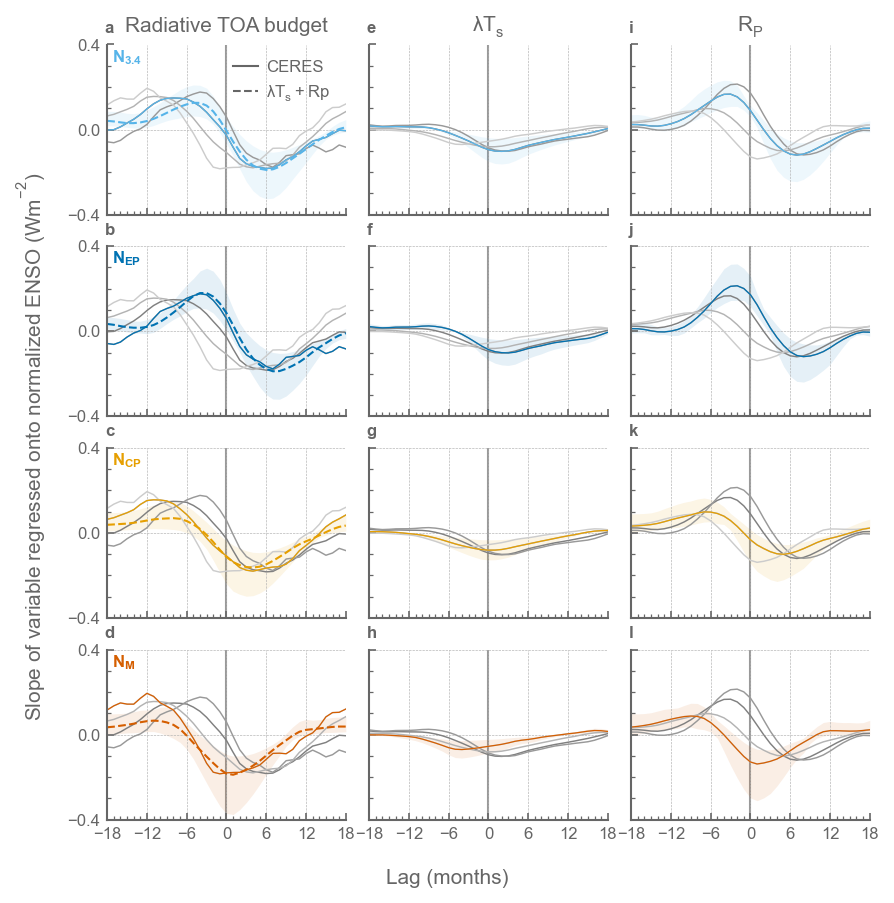

In [18]:
fig, axs = plt.subplots(4,3, figsize=(6,6), sharex=True, sharey=True)

color_per_k = [0,3,1,2]
modes = ['nino34','EP','CP','modoki']
index_names = ['N$_{3.4}$','N$_{EP}$','N$_{CP}$','N$_{M}$',]
for k in range(4):
    main_color=color_palette_enso[color_per_k[k]]
    ax=axs[k,0]
    
    ds_ceres_lag.rename(lag='time').lntime.plot(
        hue='mode', ax=ax, thick_line='mean',  
                                 color=['.5','.6','.7','.8'],
                                 line_kwargs=dict(ls='-',linewidth=.7), 
                                 shaded_area='quantiles', quantile_min=.17, quantile_max=.83,
                                 shaded_area_alpha=0, add_legend=False)
    ds_temp_lag.rename(lag='time').lntime.plot(
        hue='mode', ax=axs[k,1], thick_line='mean',  
                                 color=['.5','.6','.7','.8'],
                                 line_kwargs=dict(ls='-',linewidth=.7), 
                                 shaded_area='quantiles', quantile_min=.17, quantile_max=.83,
                                 shaded_area_alpha=0, add_legend=False)
    ds_pattern_lag.rename(lag='time').lntime.plot(
        hue='mode', ax=axs[k,2], thick_line='mean',  
                                 color=['.5','.6','.7','.8'],
                                 line_kwargs=dict(ls='-',linewidth=.7), 
                                 shaded_area='quantiles', quantile_min=.17, quantile_max=.83,
                                 shaded_area_alpha=0, add_legend=False)
    
    ds_ceres_lag.sel(mode=modes[k]).mean('product').plot(
                                ax=ax,                   
                                color=main_color, linewidth=.6
                                                        )
    (ds_pattern_lag+ds_temp_lag).sel(mode=modes[k]).rename(lag='time').lntime.plot(
                                 ax=ax, thick_line='mean',  
                                 color=main_color,
                                 line_kwargs=dict(ls='--', linewidth=1), shaded_area='quantiles', quantile_min=.05, quantile_max=.95,
                                 shaded_area_alpha=.1)
    (ds_temp_lag).sel(mode=modes[k]).rename(lag='time').lntime.plot(
                                 ax=axs[k,1], thick_line='mean',  
                                 color=main_color,
                                 line_kwargs=dict(ls='-', linewidth=.6), shaded_area='quantiles', quantile_min=.05, quantile_max=.95,
                                 shaded_area_alpha=.1)
    (ds_pattern_lag).sel(mode=modes[k]).rename(lag='time').lntime.plot(
                                 ax=axs[k,2], thick_line='mean',  
                                 color=main_color,
                                 line_kwargs=dict(ls='-', linewidth=.6), shaded_area='quantiles', quantile_min=.05, quantile_max=.95,
                                 shaded_area_alpha=.1)
    ax.text(.02,.87, index_names[k], color=main_color, weight='bold', transform=ax.transAxes, ha='left', va='bottom')
for k, ax in enumerate(axs.T.flatten()):
    ax.set(title='',ylabel='', xlabel='')
    ax.legend().remove()
    ax.set(xlim=(-18,18))
    ax.set(ylim=(-.4,.4))
    ax.xaxis.set_major_locator(plt.MultipleLocator(6))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
    ax.yaxis.set_major_locator(plt.MultipleLocator(.4))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(.1))
    ax.grid(ls='--', lw=.3, )
    ax.axvline(0, color='.6', zorder=0)
    ax.text(-.01, 1.05, chr(ord('a')+k), transform=ax.transAxes, ha='left', va='bottom', weight='bold')

custom_lines = [Line2D([0], [0], color='.4', lw=1,),
                Line2D([0], [0], color='.4', lw=1, ls='--')]
axs[0,0].legend(custom_lines, ['CERES','$\lambda T_s+Rp$'], handlelength=1.5, loc='upper right')

fig.supylabel(r'Slope of variable regressed onto normalized ENSO (Wm$^{-2}$)', size=10)
fig.supxlabel(r'Lag (months)', size=10)

axs[0,0].set_title('Radiative TOA budget')
axs[0,1].set_title(r'$\lambda T_s$')
axs[0,2].set_title('$R_P$')

plt.tight_layout(h_pad=0, w_pad=0)
plt.savefig('plots/compare_with_ceres_lag_corr.pdf')

In [19]:
df_modes_obs_mean.pi

mode
CP       -0.202570
EP        0.608802
modoki   -0.865719
nino34    0.391298
Name: pi, dtype: float64

# Supplementary figure

## Figure S1: Compare Rp ratio for all ocean basins

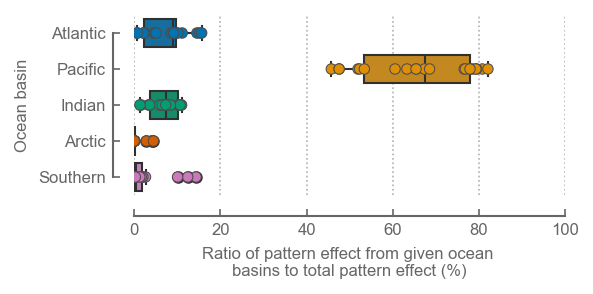

In [22]:
df_ = (100*Rp_all_basins.var('time')/Rp_total.var('time')).rename('Variance_Rp').to_series().reset_index()
sns.catplot(df_, x='Variance_Rp', hue='open_ocean',y='open_ocean', kind='box', height=2, aspect=2)
sns.stripplot(df_, x='Variance_Rp', hue='open_ocean',y='open_ocean',jitter=False, edgecolor='.3', linewidth=.5)
plt.xlim(0,100)
plt.xlabel('Ratio of pattern effect from given ocean \nbasins to total pattern effect (%)')
plt.ylabel('Ocean basin')
sns.despine(trim=True, offset=10,)
plt.tight_layout()
plt.savefig('plots_SI/Rp_with_ocean_basins.svg')

## Figure S2: All EOFs temperature patterns.

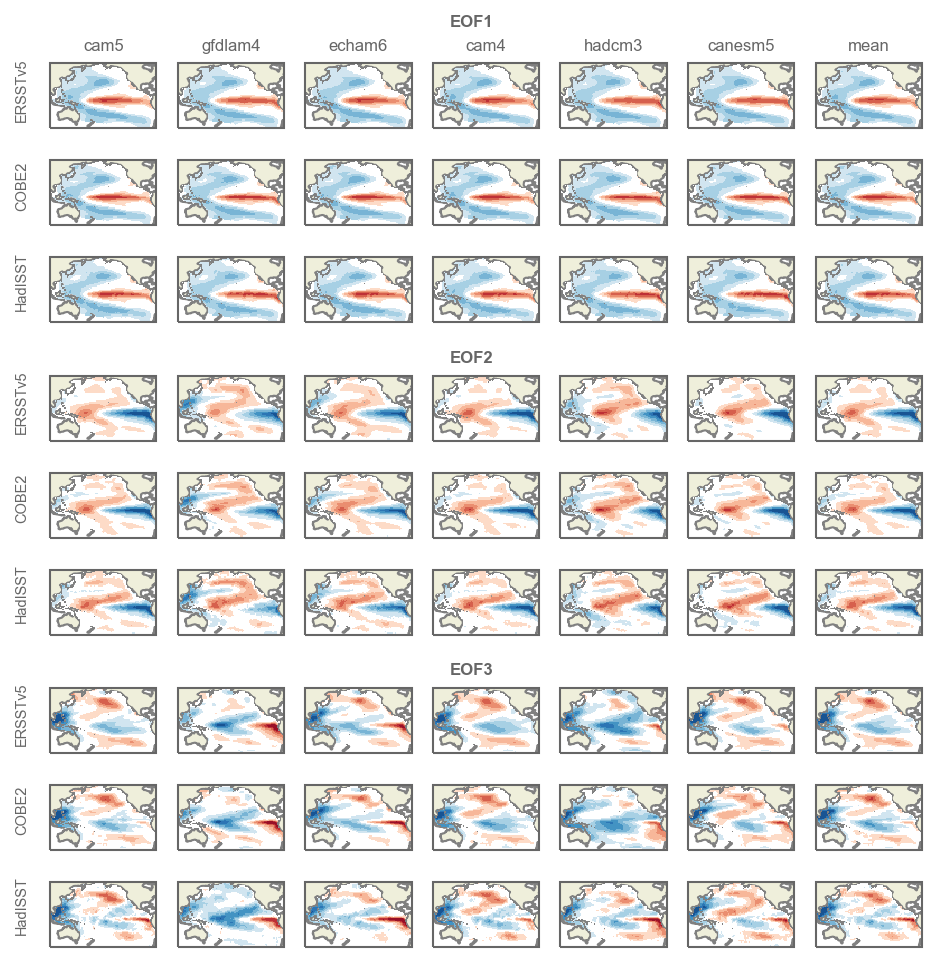

In [23]:
fig, axs = plt.subplot_mosaic(np.transpose([['EOF1-1-1','EOF1-1-2','EOF1-1-3','.','EOF2-1-1','EOF2-1-2','EOF2-1-3','.','EOF3-1-1','EOF3-1-2','EOF3-1-3','.'],
                                            ['EOF1-2-1','EOF1-2-2','EOF1-2-3','.','EOF2-2-1','EOF2-2-2','EOF2-2-3','.','EOF3-2-1','EOF3-2-2','EOF3-2-3','.'],
                                            ['EOF1-3-1','EOF1-3-2','EOF1-3-3','.','EOF2-3-1','EOF2-3-2','EOF2-3-3','.','EOF3-3-1','EOF3-3-2','EOF3-3-3','.'],
                                            ['EOF1-4-1','EOF1-4-2','EOF1-4-3','.','EOF2-4-1','EOF2-4-2','EOF2-4-3','.','EOF3-4-1','EOF3-4-2','EOF3-4-3','.'],
                                            ['EOF1-5-1','EOF1-5-2','EOF1-5-3','.','EOF2-5-1','EOF2-5-2','EOF2-5-3','.','EOF3-5-1','EOF3-5-2','EOF3-5-3','.'],
                                            ['EOF1-6-1','EOF1-6-2','EOF1-6-3','.','EOF2-6-1','EOF2-6-2','EOF2-6-3','.','EOF3-6-1','EOF3-6-2','EOF3-6-3','.'],
                                            ['EOF1-7-1','EOF1-7-2','EOF1-7-3','.','EOF2-7-1','EOF2-7-2','EOF2-7-3','.','EOF3-7-1','EOF3-7-2','EOF3-7-3','.'],
                                ]),
                                height_ratios=[10,10,10,1,10,10,10,1,10,10,10,1],
                                subplot_kw=dict(projection=ccrs.PlateCarree(200)),
                                figsize=(7.5,8), sharex=True, sharey=True)
for feature in range(1,4):
    for GF in range(eofs_pac.GF_source.size):
        for product in range(eofs_pac.product.size):
            ax = axs[f'EOF{feature:.0f}-{GF+1:.0f}-{product+1:.0f}']
            eofs_pac.components_sst.sel(feature=feature).isel(GF_source=GF, product=product).plot(ax=ax, transform=ccrs.PlateCarree(),
                                                              levels=levels_sst, colors=palette_sst,add_colorbar=False)
            if product==0 and feature==1:
                ax.set_title(f'{eofs_pac.GF_source.isel(GF_source=GF).values}', size=8)
            else:
                ax.set_title('')
            if GF_source==0:
                ax.text(0.5,0.5,f'{eofs_pac.product.isel(product=product).values}', transform=ax.transAxes, size=8, ha='left', rotation=90)
            ax.add_feature(cfeat.LAND, edgecolor='.5')

fig.text(0.5,.9,'EOF1', ha='center',va='bottom', weight='bold')
fig.text(0.5,.62,'EOF2', ha='center',va='bottom', weight='bold')
fig.text(0.5,.36,'EOF3', ha='center',va='bottom', weight='bold')

fig.text(0.1,.85,'ERSSTv5', ha='center',va='center', rotation=90, size=7)
fig.text(0.1,.77,'COBE2', ha='center',va='center', rotation=90, size=7)
fig.text(0.1,.69,'HadISST', ha='center',va='center', rotation=90, size=7)

fig.text(0.1,.85-.26,'ERSSTv5', ha='center',va='center', rotation=90, size=7)
fig.text(0.1,.77-.26,'COBE2', ha='center',va='center', rotation=90, size=7)
fig.text(0.1,.69-.26,'HadISST', ha='center',va='center', rotation=90, size=7)

fig.text(0.1,.85-.52,'ERSSTv5', ha='center',va='center', rotation=90, size=7)
fig.text(0.1,.77-.52,'COBE2', ha='center',va='center', rotation=90, size=7)
fig.text(0.1,.69-.52,'HadISST', ha='center',va='center', rotation=90, size=7)

plt.savefig('plots_SI/all_eofs_patterns.png', dpi=300)

## Figure S3: All PLSR temperature patterns.

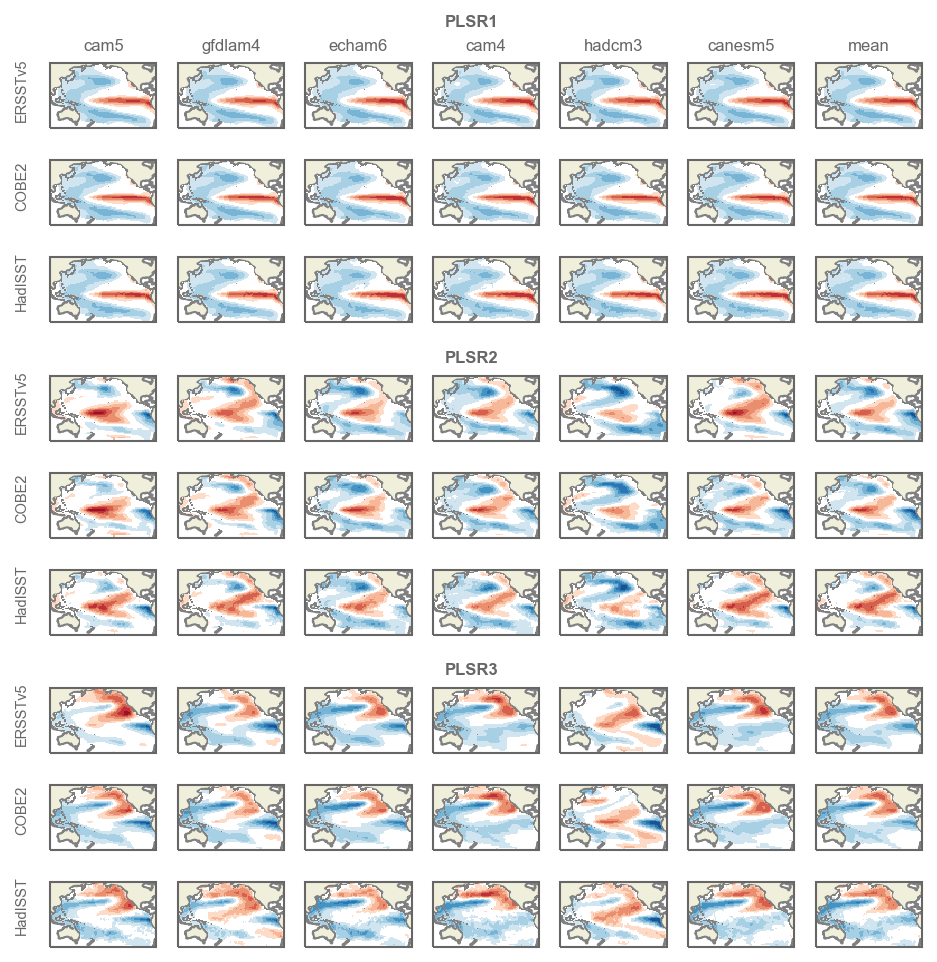

In [24]:
fig, axs = plt.subplot_mosaic(np.transpose([['PLSR1-1-1','PLSR1-1-2','PLSR1-1-3','.','PLSR2-1-1','PLSR2-1-2','PLSR2-1-3','.','PLSR3-1-1','PLSR3-1-2','PLSR3-1-3','.'],
                                            ['PLSR1-2-1','PLSR1-2-2','PLSR1-2-3','.','PLSR2-2-1','PLSR2-2-2','PLSR2-2-3','.','PLSR3-2-1','PLSR3-2-2','PLSR3-2-3','.'],
                                            ['PLSR1-3-1','PLSR1-3-2','PLSR1-3-3','.','PLSR2-3-1','PLSR2-3-2','PLSR2-3-3','.','PLSR3-3-1','PLSR3-3-2','PLSR3-3-3','.'],
                                            ['PLSR1-4-1','PLSR1-4-2','PLSR1-4-3','.','PLSR2-4-1','PLSR2-4-2','PLSR2-4-3','.','PLSR3-4-1','PLSR3-4-2','PLSR3-4-3','.'],
                                            ['PLSR1-5-1','PLSR1-5-2','PLSR1-5-3','.','PLSR2-5-1','PLSR2-5-2','PLSR2-5-3','.','PLSR3-5-1','PLSR3-5-2','PLSR3-5-3','.'],
                                            ['PLSR1-6-1','PLSR1-6-2','PLSR1-6-3','.','PLSR2-6-1','PLSR2-6-2','PLSR2-6-3','.','PLSR3-6-1','PLSR3-6-2','PLSR3-6-3','.'],
                                            ['PLSR1-7-1','PLSR1-7-2','PLSR1-7-3','.','PLSR2-7-1','PLSR2-7-2','PLSR2-7-3','.','PLSR3-7-1','PLSR3-7-2','PLSR3-7-3','.'],
                                ]),
                                height_ratios=[10,10,10,1,10,10,10,1,10,10,10,1],
                                subplot_kw=dict(projection=ccrs.PlateCarree(200)),
                                figsize=(7.5,8), sharex=True, sharey=True)
for feature in range(1,4):
    for GF in range(plsr_pac.GF_source.size):
        for product in range(plsr_pac.product.size):
            ax = axs[f'PLSR{feature:.0f}-{GF+1:.0f}-{product+1:.0f}']
            plsr_pac.components_sst.sel(feature=feature).isel(GF_source=GF, product=product).plot(ax=ax, transform=ccrs.PlateCarree(),
                                                              levels=levels_sst, colors=palette_sst,add_colorbar=False)
            if product==0 and feature==1:
                ax.set_title(f'{plsr_pac.GF_source.isel(GF_source=GF).values}', size=8)
            else:
                ax.set_title('')
            if GF_source==0:
                ax.text(0.5,0.5,f'{plsr_pac.product.isel(product=product).values}', transform=ax.transAxes, size=8, ha='left', rotation=90)
            ax.add_feature(cfeat.LAND, edgecolor='.5')

fig.text(0.5,.9,'PLSR1', ha='center',va='bottom', weight='bold')
fig.text(0.5,.62,'PLSR2', ha='center',va='bottom', weight='bold')
fig.text(0.5,.36,'PLSR3', ha='center',va='bottom', weight='bold')

fig.text(0.1,.85,'ERSSTv5', ha='center',va='center', rotation=90, size=7)
fig.text(0.1,.77,'COBE2', ha='center',va='center', rotation=90, size=7)
fig.text(0.1,.69,'HadISST', ha='center',va='center', rotation=90, size=7)

fig.text(0.1,.85-.26,'ERSSTv5', ha='center',va='center', rotation=90, size=7)
fig.text(0.1,.77-.26,'COBE2', ha='center',va='center', rotation=90, size=7)
fig.text(0.1,.69-.26,'HadISST', ha='center',va='center', rotation=90, size=7)

fig.text(0.1,.85-.52,'ERSSTv5', ha='center',va='center', rotation=90, size=7)
fig.text(0.1,.77-.52,'COBE2', ha='center',va='center', rotation=90, size=7)
fig.text(0.1,.69-.52,'HadISST', ha='center',va='center', rotation=90, size=7)
# plt.tight_layout()
plt.savefig('plots_SI/all_plsr_patterns.png', dpi=300)

## Figure S4: Reproduced analysis with the global ocean.

To reproduce this figure, rerun the notebook by changing SSTA_pac by SSTA_detrend and Rp_pac by Rp_total in the processing. That can be done by adding two lines before the EOF and PLSR analysis:

SSTA_pac = SSTA_detrend

Rp_pac = Rp_total

Or by renaming these variables during the processing.

## Figure S5: compare pattern differences

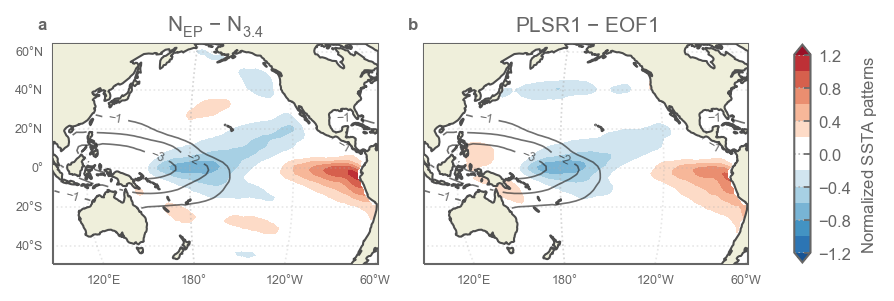

In [25]:

fig, axs = plt.subplot_mosaic("""
                              ABx
                              """,
                              figsize=(6,2),
                              width_ratios=[20,20,1],
                              per_subplot_kw=dict(AB=dict(projection=ccrs.Robinson(200))))

palette_sst=sns.color_palette('RdBu_r',n_colors=14)
palette_sst[6] = (1,1,1)
palette_sst[7] = (1,1,1)



levels_sst = np.arange(-1.2,1.3,.2) 

plsr1 = plsr_pac.components_sst.isel(feature=0).mean(['GF_source','product'])
eof1 = eofs_pac.components_sst.isel(feature=0).mean(['GF_source','product'])
diff_enso = (modes_pattern_mean.sel(mode='EP') - modes_pattern_mean.sel(mode='nino34')).interpolate_na('lon')
diff_feature1 = (plsr1-eof1).interpolate_na('lon')

diff_enso.plot.contourf(ax=axs['A'], cbar_ax=axs['x'], levels=levels_sst, colors=palette_sst, extend='both', transform=ccrs.PlateCarree())
diff_feature1.plot.contourf(ax=axs['B'], cbar_ax=axs['x'], levels=levels_sst, colors=palette_sst, extend='both', transform=ccrs.PlateCarree())



axs['x'].set_yticks(np.arange(-1.2,1.3,.4))
axs['x'].minorticks_off()
axs['x'].set_ylabel(r'Normalized $SSTA$ patterns')


all_axs = ['A','B']
for k,letter in enumerate(all_axs):
    ax=axs[letter]
    ax.add_feature(cfeat.LAND, edgecolor='.3', zorder=100)
    ax.set_title('')
    c = (mean_gf.sel(lon=mean_eofs.lon, lat=mean_eofs.lat)*1000).plot.contour(levels=[-4,-3,-2,-1], extend='both', ax=ax, 
                                                                          zorder=1000, colors='.2', transform=ccrs.PlateCarree(),
                                                                          linewidths=.8, linestyles=['-','-','-','-','--'], alpha=.7)
    ax.clabel(c, c.levels, fmt=None, fontsize=6)
    gl = ax.gridlines(draw_labels=True, alpha=.3)
    if True:
        gl.top_labels=False
    if letter not in ['A','D','M','G','J']:
        gl.left_labels=False
    gl.ylabel_style=dict(size=6)
    gl.xlabel_style=dict(size=6)
    label = chr(ord('a')+k)
    ax.text(-.05,1.05, label, weight='bold', ha='left', va='bottom', transform=ax.transAxes)
    ax.set_ylabel('')

axs['A'].set_title('$N_{EP}$ $\minus$ $N_{3.4}$')
axs['B'].set_title('PLSR1 $\minus$ EOF1')
plt.tight_layout()
plt.savefig('plots_SI/S1_comparing_pattern_differences.svg', dpi=300)


## Figure S6: ENSO indices in CP EP space

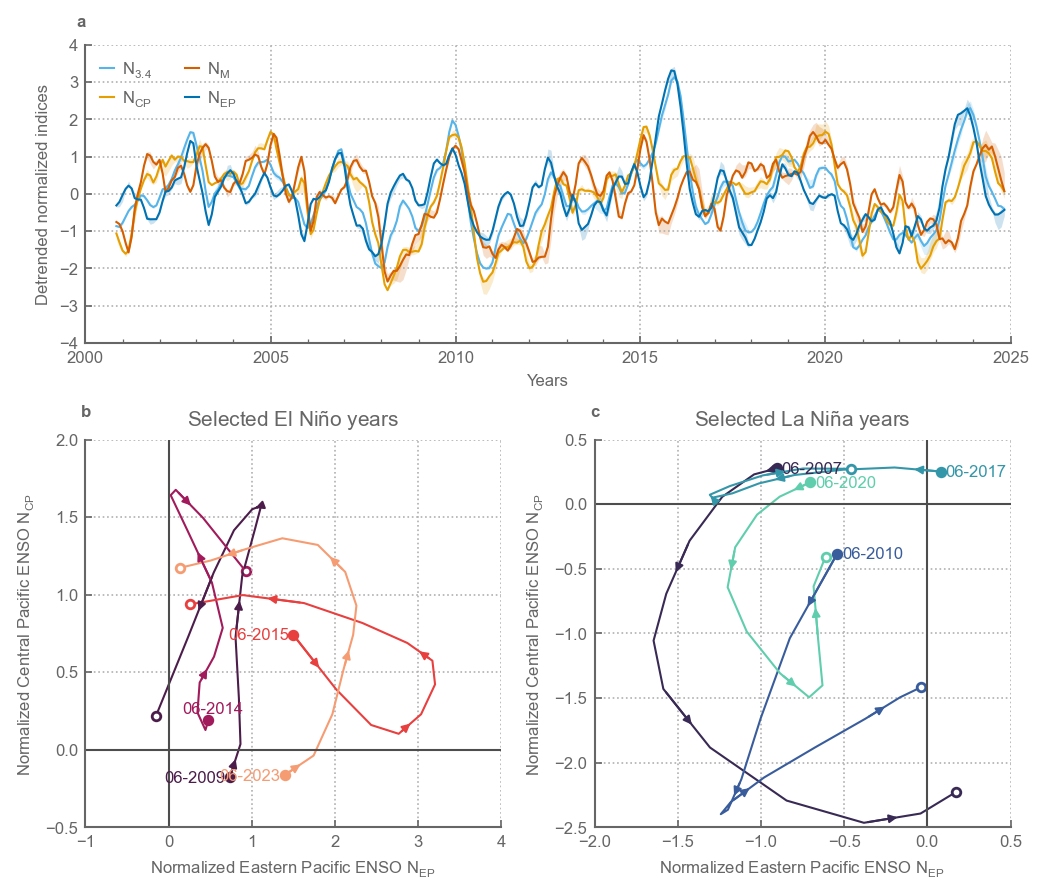

In [26]:
from matplotlib.dates import YearLocator

ninoyears = [2009,2014,2015,2023]
ninayears = [2007,2010,2017,2020]

fig, axs = plt.subplot_mosaic("""
                              CC
                              AB
                              """,
                              figsize = (7,6),
                              height_ratios=(1,1.3))


modes_notrend.sel(mode=['nino34','CP','modoki','EP']).lntime.plot(ax=axs['C'], hue='mode',color=color_palette_enso)
axs['C'].xaxis.set_major_locator(YearLocator(5))
axs['C'].xaxis.set_minor_locator(YearLocator(1))
axs['C'].set_xlim(pd.to_datetime(('2000','2025')))
axs['C'].set_ylim(-4,4)
axs['C'].set_title('')
axs['C'].set_xlabel('Years')
axs['C'].set_ylabel('Detrended normalized indices')

axs['C'].legend(["$N_{3.4}$","$N_{CP}$","$N_{M}$","$N_{EP}$", ], ncols=2)




ninocolors = sns.color_palette('rocket', n_colors=len(ninoyears))
for k,year in enumerate(ninoyears):
    df_ = modes_notrend.rolling(time=3,center=True).mean().sel(time=slice(f"{year}-06",f"{year+1}-05")).mean('product').to_series().unstack().T
    df_.plot.line(x='EP',y='CP', ax=axs['A'], label=year, color=ninocolors[k], legend=False)
    df_.iloc[-1:].plot.scatter(x='EP',y='CP', ax=axs['A'], s=3, color='white', zorder=100)
    df_.iloc[::df_.index.size-1].plot.scatter(x='EP',y='CP', ax=axs['A'],  color=ninocolors[k])
    df_['dx']=df_.EP.diff().shift(-1)
    df_['dy']=df_.CP.diff().shift(-1)
    df_traj = df_.iloc[::3]
    for i in range(0, df_traj.index.size):
        axs['A'].annotate("", xytext=(df_traj.EP.iloc[i], df_traj.CP.iloc[i]), xy=(df_traj.EP.iloc[i] + df_traj.dx.iloc[i]/1.5, df_traj.CP.iloc[i]+ df_traj.dy.iloc[i]/1.5),
            arrowprops=dict(arrowstyle="-|>", color=ninocolors[k]),)
    if year==2014:
        axs['A'].text(df_.iloc[0].EP+.05,df_.iloc[0].CP+.02,f"06-{year}", va='bottom', ha='center',color=ninocolors[k], zorder=100)
    else:
        axs['A'].text(df_.iloc[0].EP-.05,df_.iloc[0].CP-.005,f"06-{year}", va='center', ha='right',color=ninocolors[k], zorder=100)
    # axs['C'].axvline(pd.to_datetime(f"06-{year}"), color=ninocolors[k])


ninacolors = sns.color_palette('mako', n_colors=len(ninayears))
for k,year in enumerate(ninayears):
    df_ = modes_notrend.rolling(time=3,center=True).mean().sel(time=slice(f"{year}-06",f"{year+1}-05")).mean('product').to_series().unstack().T
    axs['B'].plot(df_.EP, df_.CP, color=ninacolors[k], )
    df_.iloc[-1:].plot.scatter(x='EP',y='CP', ax=axs['B'], s=3, color='white', zorder=100)
    df_.iloc[::df_.index.size-1].plot.scatter(x='EP',y='CP', ax=axs['B'],  color=ninacolors[k], legend=False)
    df_['dx']=df_.EP.diff().shift(-1)
    df_['dy']=df_.CP.diff().shift(-1)
    df_traj = df_.iloc[::3]
    for i in range(0, df_traj.index.size):
        axs['B'].annotate("", xytext=(df_traj.EP.iloc[i], df_traj.CP.iloc[i]), xy=(df_traj.EP.iloc[i] + df_traj.dx.iloc[i]/1.5, df_traj.CP.iloc[i]+ df_traj.dy.iloc[i]/1.5),
            arrowprops=dict(arrowstyle="-|>", color=ninacolors[k]),)
    # axs['C'].axvline(pd.to_datetime(f"06-{year}"), color=ninacolors[k])
    axs['B'].text(df_.EP.iloc[0]+.03,df_.CP.iloc[0]-.005,f"06-{year}", va='center', color=ninacolors[k])
# axs['B'].get_legend().remove()
# axs['A'].legend().remove()

axs['A'].axhline(0, color='.3')
axs['A'].axvline(0, color='.3')
axs['B'].axhline(0, color='.3')
axs['B'].axvline(0, color='.3')
axs['A'].set(xlim=(-1,4), ylim=(-.5,2), xlabel='Normalized Eastern Pacific ENSO $N_{EP}$ ', ylabel='Normalized Central Pacific ENSO $N_{CP}$ ', title='Selected El $Ni\~no$ years')
axs['B'].set(xlim=(-2,.5), ylim=(-2.5,.5), xlabel='Normalized Eastern Pacific ENSO $N_{EP}$ ', ylabel='Normalized Central Pacific ENSO $N_{CP}$ ', title='Selected La $Ni\~na$ years')

axs['A'].text(-.01, 1.05, 'b', transform=axs['A'].transAxes, ha='left', va='bottom', weight='bold')
axs['B'].text(-.01, 1.05, 'c', transform=axs['B'].transAxes, ha='left', va='bottom', weight='bold')
axs['C'].text(-.01, 1.05, 'a', transform=axs['C'].transAxes, ha='left', va='bottom', weight='bold')

plt.tight_layout()
plt.savefig('plots_SI/BONUS_ENSO_cycles.svg', dpi=300)


# Supplementary tables

In [27]:
def bold_if_gt_half(v):
    if pd.api.types.is_number(v) and pd.notna(v) and v > 0.5:
        return "font-weight: bold"
    return ""
def color_row_max(s: pd.Series, color: str):
    m = s == s.max(skipna=True)          # ties allowed; NaNs ignored
    return [f"color: {color}" if flag else "" for flag in m]

# Choose your column groups
  # last 4 numeric cols



## Table S1: correlations of modes with EOF1

In [28]:
df_ = df_regr_all.query("feature=='Feature 1' & method =='EOFs' & mode.isin(['nino34','modoki','CP','EP'])")
df__ = (df_.pivot(columns='mode', index=['GF_source','product'], values=['regr_space','regr_time'])**2).round(2)
df__ = df__.rename(columns=dict(regr_space='Spatial r2', regr_time='Temporal r2'))

num = df__.select_dtypes(include="number").columns
first4 = [c for c in df__.columns[:4]  if c in num]   # first 4 numeric cols
last4  = [c for c in df__.columns[-4:] if c in num] 

df_format = df__.style.format("{:.2f}")
styler = (
    df__.style
      .format("{:.2f}")                 # your numeric formatting
      .applymap(bold_if_gt_half)        # make >0.5 bold
        .apply(color_row_max, axis=1, subset=first4, color="red")      # max of first 4 → red
      .apply(color_row_max, axis=1, subset=last4,  color="purple")
)
styler.to_excel('SI_tables/EOF1_correlations.xlsx')
styler

/tmp/ipykernel_77958/3765401109.py:13: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(bold_if_gt_half)        # make >0.5 bold


## Table S2: correlations of modes with EOF2

In [29]:
df_ = df_regr_all.query("feature=='Feature 2' & method =='EOFs' & mode.isin(['nino34','modoki','CP','EP'])")
df__ = (df_.pivot(columns='mode', index=['GF_source','product'], values=['regr_space','regr_time'])**2).round(2)
df__ = df__.rename(columns=dict(regr_space='Spatial r2', regr_time='Temporal r2'))

num = df__.select_dtypes(include="number").columns
first4 = [c for c in df__.columns[:4]  if c in num]   # first 4 numeric cols
last4  = [c for c in df__.columns[-4:] if c in num] 

df_format = df__.style.format("{:.2f}")
styler = (
    df__.style
      .format("{:.2f}")                 # your numeric formatting
      .applymap(bold_if_gt_half)        # make >0.5 bold
        .apply(color_row_max, axis=1, subset=first4, color="red")      # max of first 4 → red
      .apply(color_row_max, axis=1, subset=last4,  color="purple")
)
styler.to_excel('SI_tables/EOF2_correlations.xlsx')
styler

/tmp/ipykernel_77958/4215479021.py:13: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(bold_if_gt_half)        # make >0.5 bold


## Table S3: correlations of modes with EOF3

In [30]:
df_ = df_regr_all.query("feature=='Feature 3' & method =='EOFs' & mode.isin(['nino34','modoki','CP','EP'])")
df__ = (df_.pivot(columns='mode', index=['GF_source','product'], values=['regr_space','regr_time'])**2).round(2)
df__ = df__.rename(columns=dict(regr_space='Spatial r2', regr_time='Temporal r2'))

num = df__.select_dtypes(include="number").columns
first4 = [c for c in df__.columns[:4]  if c in num]   # first 4 numeric cols
last4  = [c for c in df__.columns[-4:] if c in num] 

df_format = df__.style.format("{:.2f}")
styler = (
    df__.style
      .format("{:.2f}")                 # your numeric formatting
      .applymap(bold_if_gt_half)        # make >0.5 bold
        .apply(color_row_max, axis=1, subset=first4, color="red")      # max of first 4 → red
      .apply(color_row_max, axis=1, subset=last4,  color="purple")
)
styler.to_excel('SI_tables/EOF3_correlations.xlsx')
styler

/tmp/ipykernel_77958/3867970262.py:13: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(bold_if_gt_half)        # make >0.5 bold


## Table S4: correlations of modes with PLSR1

In [31]:
df_ = df_regr_all.query("feature=='Feature 1' & method =='PLSR' & mode.isin(['nino34','modoki','CP','EP'])")
df__ = (df_.pivot(columns='mode', index=['GF_source','product'], values=['regr_space','regr_time'])**2).round(2)
df__ = df__.rename(columns=dict(regr_space='Spatial r2', regr_time='Temporal r2'))

num = df__.select_dtypes(include="number").columns
first4 = [c for c in df__.columns[:4]  if c in num]   # first 4 numeric cols
last4  = [c for c in df__.columns[-4:] if c in num] 

df_format = df__.style.format("{:.2f}")
styler = (
    df__.style
      .format("{:.2f}")                 # your numeric formatting
      .applymap(bold_if_gt_half)        # make >0.5 bold
        .apply(color_row_max, axis=1, subset=first4, color="red")      # max of first 4 → red
      .apply(color_row_max, axis=1, subset=last4,  color="purple")
)
styler.to_excel('SI_tables/PLSR1_correlations.xlsx')
styler

/tmp/ipykernel_77958/384099161.py:13: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(bold_if_gt_half)        # make >0.5 bold


## Table S5: correlations of modes with PLSR2

In [32]:
df_ = df_regr_all.query("feature=='Feature 2' & method =='PLSR' & mode.isin(['nino34','modoki','CP','EP'])")
df__ = (df_.pivot(columns='mode', index=['GF_source','product'], values=['regr_space','regr_time'])**2).round(2)
df__ = df__.rename(columns=dict(regr_space='Spatial r2', regr_time='Temporal r2'))

num = df__.select_dtypes(include="number").columns
first4 = [c for c in df__.columns[:4]  if c in num]   # first 4 numeric cols
last4  = [c for c in df__.columns[-4:] if c in num] 

df_format = df__.style.format("{:.2f}")
styler = (
    df__.style
      .format("{:.2f}")                 # your numeric formatting
      .applymap(bold_if_gt_half)        # make >0.5 bold
        .apply(color_row_max, axis=1, subset=first4, color="red")      # max of first 4 → red
      .apply(color_row_max, axis=1, subset=last4,  color="purple")
)
styler.to_excel('SI_tables/PLSR2_correlations.xlsx')
styler

/tmp/ipykernel_77958/1735708054.py:13: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(bold_if_gt_half)        # make >0.5 bold


## Table S6: correlations of modes with PLSR3

In [33]:
df_ = df_regr_all.query("feature=='Feature 3' & method =='PLSR' & mode.isin(['nino34','modoki','CP','EP'])")
df__ = (df_.pivot(columns='mode', index=['GF_source','product'], values=['regr_space','regr_time'])**2).round(2)
df__ = df__.rename(columns=dict(regr_space='Spatial r2', regr_time='Temporal r2'))

num = df__.select_dtypes(include="number").columns
first4 = [c for c in df__.columns[:4]  if c in num]   # first 4 numeric cols
last4  = [c for c in df__.columns[-4:] if c in num] 

df_format = df__.style.format("{:.2f}")
styler = (
    df__.style
      .format("{:.2f}")                 # your numeric formatting
      .applymap(bold_if_gt_half)        # make >0.5 bold
        .apply(color_row_max, axis=1, subset=first4, color="red")      # max of first 4 → red
      .apply(color_row_max, axis=1, subset=last4,  color="purple")
)
styler.to_excel('SI_tables/PLSR3_correlations.xlsx')
styler

/tmp/ipykernel_77958/2518676225.py:13: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(bold_if_gt_half)        # make >0.5 bold


# Test warmpool

In [55]:
print(xr_linregress(modes_obs.mode_timeseries.sel(mode='CP'), modes_obs.mode_timeseries.sel(mode='EP')).r_value.values.mean()**2)
print((xr_linregress(plsr_pac.timeseries.sel(feature=1), modes_obs.mode_timeseries.sel(mode='CP')).r_value**2).mean().values)

0.032081613812377494
0.15179726124294654


In [45]:
plsr_pac.timeseries

<xarray.DataArray 'timeseries' (product: 3, GF_source: 7, time: 780, feature: 3)> Size: 393kB
array([[[[        nan,         nan,         nan],
         [ 0.60224221, -0.4850586 , -0.59729693],
         [ 0.64490864, -0.25518149, -0.35787183],
         ...,
         [-0.19706019,  0.02552378,  0.50032548],
         [-0.27454962, -0.11010126,  0.17430929],
         [        nan,         nan,         nan]],

        [[        nan,         nan,         nan],
         [ 0.56979525, -0.34281193, -0.26374722],
         [ 0.61666622, -0.09242302, -0.21583942],
         ...,
         [-0.17640478, -0.12000878,  0.28861428],
         [-0.27207849, -0.12115056, -0.08703351],
         [        nan,         nan,         nan]],

        [[        nan,         nan,         nan],
         [ 0.55617171,  0.08219929, -0.58842648],
         [ 0.54276836,  0.32277276, -0.57325442],
         ...,
...
         ...,
         [-0.33223375,  0.39719322,  0.86955267],
         [-0.41451441,  0.32362677,  0.32649131],
         [        nan,         nan,         nan]],

        [[        nan,         nan,         nan],
         [ 0.43617442, -0.28104577, -0.089055  ],
         [ 0.42791478,  0.04826452, -0.05540362],
         ...,
         [-0.27794631,  0.14407368,  0.62263449],
         [-0.31646973, -0.15599417,  0.34947418],
         [        nan,         nan,         nan]],

        [[        nan,         nan,         nan],
         [ 0.38166389, -0.00699109, -0.24412974],
         [ 0.37696695,  0.31225279, -0.18239809],
         ...,
         [-0.26849242,  0.10005795,  0.55637089],
         [-0.31635014, -0.15632866,  0.24762785],
         [        nan,         nan,         nan]]]])
Coordinates:
  * time       (time) datetime64[ns] 6kB 1960-01-01 1960-02-01 ... 2024-12-01
  * GF_source  (GF_source) <U7 196B 'cam5' 'gfdlam4' ... 'canesm5' 'mean'
  * product    (product) <U7 84B 'ERSSTv5' 'COBE2' 'HadISST'
  * feature    (feature) int64 24B 1 2 3

In [38]:
modes_obs

<xarray.Dataset> Size: 612kB
Dimensions:          (product: 3, mode: 4, lat: 58, lon: 95, time: 778,
                      GF_source: 7)
Coordinates:
  * product          (product) <U7 84B 'ERSSTv5' 'COBE2' 'HadISST'
  * mode             (mode) <U6 96B 'nino34' 'CP' 'EP' 'modoki'
  * lat              (lat) float64 464B 65.0 63.0 61.0 ... -45.0 -47.0 -49.0
  * lon              (lon) float64 760B 101.0 103.0 105.0 ... 285.0 287.0 289.0
  * time             (time) datetime64[ns] 6kB 1960-02-01 ... 2024-11-01
  * GF_source        (GF_source) <U7 196B 'cam5' 'gfdlam4' ... 'canesm5' 'mean'
Data variables:
    mode_pattern     (mode, product, lat, lon) float64 529kB nan nan ... nan nan
    mode_timeseries  (mode, product, time) float64 75kB -0.0933 ... 0.1866
    lambdas_space    (mode, product) float64 96B 0.2949 0.2958 ... 0.1438 0.1426
    lambdas          (mode, product) float64 96B 0.2949 0.2958 ... 0.1438 0.1426
    pi               (mode, product, GF_source) float64 672B 0.5976 ... -0.8629

In [117]:
df_cum_mean.set_index(['feature','method']).unstack()

var_ratio           
method        EOFs   plPLSRsr
feature                      
1        14.497803  43.474797
2        58.571121  74.721813
3        83.532832  88.222755
4        85.708673  96.716926
5        88.158388  98.566955
6        90.810587  99.290916
7        94.101301  99.592959
8        94.785294  99.754491
9        95.122699  99.842383
10       95.418185  99.891852
11       95.581346  99.924728
12       95.793168  99.943608
13       96.001942  99.960343
14       96.205347  99.968772
15       96.364923  99.975559
16       96.438956  99.980792
17       96.543712  99.984996
18       96.676685  99.987938
19       96.749841  99.990282
20       96.832880  99.991932